### [Momentum Strategy](#momentum)
<br>

### [Mean Reversion Strategy](#meanreversion)
<br>

### [Machine Learning Strategy](#ml)
<br>

### [Results and Summary](#results)

In [1309]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf


np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

<a id="momentum"></a>
### Momentum Strategy

In [1310]:
start = dt.datetime(2003, 11, 1)
end = dt.datetime(2022, 10, 31)

data = pdr.get_data_yahoo("SPY",
                        start = start,
                        end = end)

SPY = data.drop(['High','Low','Open','Close','Volume'], axis=1)
SPY

,Adj Close
Date,
2003-10-31,72.903069
2003-11-03,73.380798
2003-11-04,73.221550
2003-11-05,73.276924
2003-11-06,73.664604
...,...
2022-10-25,384.920013
2022-10-26,382.019989
2022-10-27,379.980011


> To find the optimal strategy, we first optimise using an optimisation window, and test the optimised parameters on the out-sample period

In [1313]:
validation_size = 0.20
train_size = int(len(SPY) * (1 - validation_size))
train_set, test_set = SPY[0:train_size], SPY[train_size:len(SPY)]

> We define functions below for Momentum strategy, and the tuning process

In [1424]:
# sharpe ratio
def Sharpe_ratio(col):
    mean = np.sqrt(252) * col.mean()
    std = col.std()
    return mean / std

# creating dataframe for momentum strategy
def momentum_strat(df, short_period, long_period):   
    df = df.copy()
    df['EMA_SHORT'] = df["Adj Close"].ewm(span = short_period, min_periods=short_period, adjust=False).mean()
    df['EMA_LONG'] = df["Adj Close"].ewm(span = long_period, min_periods=long_period, adjust=False).mean()
    df = df.dropna()
    df["EMA_POSITIONS"] = np.where(df["EMA_SHORT"] < df["EMA_LONG"], -1, 1)
    df['RETURNS'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1)).fillna(0)
    df['EWA_RETURNS'] = (df['EMA_POSITIONS'].shift(1) * df['RETURNS']).fillna(0)
    df['CUMULATIVE_RETURNS'] = df['RETURNS'].cumsum().apply(np.exp)
    df['CUMULATIVE_STRATEGY_RETURNS'] = df['EWA_RETURNS'].cumsum().apply(np.exp)
    df["MAX_GROSS_PERFORMANCE"] = df["CUMULATIVE_STRATEGY_RETURNS"].cummax()
    df['DRAWDOWN'] = (df['MAX_GROSS_PERFORMANCE'] - df["CUMULATIVE_STRATEGY_RETURNS"]) / df['MAX_GROSS_PERFORMANCE']
    
    return df

# window tuning
# looping to find best returns from varying short and long periods

def find_optimal_strategy(spy, criterion):
    results_df = []

    for long_period in range(41, 100):
        for short_period in range(10, 40): 
            # print("Checking short={}, long={}".format(short_period, long_period))
            df = momentum_strat(spy, short_period=short_period, long_period=long_period)

            results_df.append({
                'df': df,
                'returns': df.iloc[-1]['CUMULATIVE_STRATEGY_RETURNS'],
                'short_period': short_period,
                'long_period': long_period,
                'sharpe' : Sharpe_ratio(df['EWA_RETURNS'].apply(np.exp) - 1)
            })

    results_df = pd.DataFrame(results_df)

    if criterion == 'sharpe':
        results_df = results_df[results_df['sharpe'] == results_df['sharpe'].max()]
    elif criterion == 'returns':
        results_df = results_df[results_df['returns'] == results_df['returns'].max()]
    else:
        pass

    return results_df


In [1589]:
def backtest(pnl,benchmark,capital,label):
    pnl = pnl
    cumpnl = ((1 + pnl).cumprod()) * capital
    sharpe = pnl.mean()/np.std(pnl) * np.sqrt(252)
    downsidepnl = pnl[pnl<0]
    sortino = pnl.mean()/np.std(downsidepnl) * np.sqrt(252)
    highwatermark_df = cumpnl.cummax() + 1
    drawdown_df = ((1+cumpnl) - highwatermark_df) / highwatermark_df
    maxdrawdown = drawdown_df.min()
    # benchmark
    benchmark = benchmark
    cumpnl_bm = ((1+benchmark).cumprod()) * capital
    sharpe_bm = benchmark.mean()/np.std(benchmark) * np.sqrt(252)
    downsidepnl_bm = benchmark[benchmark<0]
    sortino_bm = benchmark.mean()/np.std(downsidepnl_bm) * np.sqrt(252)
    highwatermark_df_bm = cumpnl_bm.cummax() + 1
    drawdown_df_bm = ((1+cumpnl_bm) - highwatermark_df_bm) / highwatermark_df_bm
    maxdrawdown_bm = drawdown_df_bm.min()
    print("")
    print('Performance Statistics for '+label)
    print('Daily annualized sharpe: '+str(sharpe))
    print('Daily annualized sortino: '+str(sortino))
    print('Average annual returns: '+str(pnl.mean()*252*100)+'%')
    print('Total cumulative returns: '+str(cumpnl.iloc[-1]/capital*100)+'%')
    print('Max drawdown: '+str(maxdrawdown*100)+'%')
    print("")
    print("")
    print('Performance Statistics for Benchmark')
    print('Daily annualized sharpe: '+str(sharpe_bm))
    print('Daily annualized sortino: '+str(sortino_bm))
    print('Average annual returns: '+str(benchmark.mean()*252*100)+'%')
    print('Total cumulative returns: '+str(cumpnl_bm.iloc[-1]/capital*100)+'%')
    print('Max drawdown: '+str(maxdrawdown_bm*100)+'%')
    print("")
    plt.figure(figsize=(10,6))
    plt.plot(cumpnl.index, cumpnl.values, label = label)
    plt.plot(cumpnl_bm.index, cumpnl_bm.values, label = 'Benchmark')
    plt.legend()
    plt.title('Cumulative PNL chart')
    plt.show(block=False)

    # return periods
    returnperiods = dict()
    returnperiods['YTD'] = (dt.datetime(2021, 12, 31), dt.datetime(2022, 10, 31))
    returnperiods['1y'] = (dt.datetime(2021, 10, 29), dt.datetime(2022, 10, 31))
    returnperiods['3y'] = (dt.datetime(2019, 10, 31), dt.datetime(2022, 10, 31))
    returnperiods['2021'] = (dt.datetime(2020, 12, 31), dt.datetime(2021, 12, 31))
    returnperiods['2020'] = (dt.datetime(2019, 12, 31), dt.datetime(2020, 12, 31))
    returnperiods['2019'] = (dt.datetime(2018, 12, 31), dt.datetime(2019, 12, 31))
    # returnperiods['2018'] = (dt.datetime(2018, 4, 17), dt.datetime(2018, 12, 31))
    print()
    print('Total Return')
    print('===================================')

    print('Return: Portfolio')
    for tkey in returnperiods.keys():
        mask = pnl.index.to_series().between(returnperiods[tkey][0], returnperiods[tkey][1])
        periodpnl = ((1+pnl[mask]).cumprod() - 1)
        print('Period return '+tkey+': '+str((periodpnl*100).iloc[-1])+'%')
    print('===================================')
    print('')

    print('Return: Benchmark')
    for tkey in returnperiods.keys():
        mask = benchmark.index.to_series().between(returnperiods[tkey][0], returnperiods[tkey][1])
        periodpnl = ((1+benchmark[mask]).cumprod() - 1)
        print('Period return '+tkey+': '+str((periodpnl*100).iloc[-1])+'%')
    print('===================================')
    print('')

    # return periods
    annreturnperiods = dict()
    days = len(pnl)
    alltime = days/252
    years_list = (alltime,5)
    annreturnperiods['All-time'] = (pnl.index[0], pnl.index[-1])
    annreturnperiods['3y'] = (dt.datetime(2019, 10, 31), dt.datetime(2022, 10, 31))
    print('Annualized Return')
    print('===================================')

    for tkey,years in zip(annreturnperiods.keys(),years_list):
        mask = pnl.index.to_series().between(annreturnperiods[tkey][0], annreturnperiods[tkey][1])
        annpnl = ((1+pnl[mask]).cumprod() - 1)
        ann_return = (1+annpnl.iloc[-1]) ** (1/years) - 1
        print('Period return '+tkey+': '+str(ann_return*100)+'%')
    print('===================================')
    print('')

    for tkey,years in zip(annreturnperiods.keys(),years_list):
        mask = benchmark.index.to_series().between(annreturnperiods[tkey][0], annreturnperiods[tkey][1])
        annpnl = ((1+benchmark[mask]).cumprod() - 1)
        ann_return = (1+annpnl.iloc[-1]) ** (1/years) - 1
        print('Period return '+tkey+': '+str(ann_return*100)+'%')
    print('===================================')
    print('')

    # stress test
    stressedmarkets = dict() 
    stressedmarkets['Inflation22'] = (dt.datetime(2022, 4, 20), dt.datetime(2022, 5, 20))     #Fed hawkish monetary policy
    stressedmarkets['Covid19'] = (dt.datetime(2020, 3, 1), dt.datetime(2020, 3, 23))          #Market crash 1H March 2020
    # stressedmarkets['Dec18'] = (dt.datetime(2018, 12, 15), dt.datetime(2018, 12, 31))            #Market crash last 2 weeks
    print('Stress Tests')
    print('===================================')

    for tkey in stressedmarkets.keys():
        mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
        stressreturn = ((1+pnl[mask]).cumprod() - 1)
        print('Stressed period return during '+tkey+': '+str(stressreturn.min()*100)+'%')
    print('===================================')
    print('')

    for tkey in stressedmarkets.keys():
        mask = benchmark.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
        stressreturn = ((1+benchmark[mask]).cumprod() - 1)
        print('Stressed period return during '+tkey+': '+str(stressreturn.min()*100)+'%')
    print('===================================')
    print('')

> We used the max sharpe criterion to optimise for best performing EWMA short and long windows to use momentum strategy on

> To ensure we can compare identical time periods in backtest, we used the same timeframe as the ML model where the momentum strategy can start (Since ML has more constraints)

**Similar to GridSearch, we iterate through all combinations of long and short windows to find the best performing combination**

In [1316]:
momentum_train = train_set.copy()
momentum_test = test_set.copy()

find_optimal_strategy(momentum_train,'sharpe')

,df,returns,short_period,long_period,sharpe
631,Adj Close EMA_SHORT EMA_LONG...,3.264436,11,62,0.494916


In [1425]:
momentum_spy = momentum_strat(momentum_test, short_period=11, long_period=62)
momentum_spy = momentum_spy.fillna(1)
momentum_spy

,Adj Close,EMA_SHORT,EMA_LONG,EMA_POSITIONS,RETURNS,EWA_RETURNS,CUMULATIVE_RETURNS,CUMULATIVE_STRATEGY_RETURNS,MAX_GROSS_PERFORMANCE,DRAWDOWN
Date,,,,,,,,,,
2019-04-12,273.913605,270.934754,261.742199,1,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00
2019-04-15,273.734253,271.401337,262.122899,1,-0.000655,-0.000655,0.999345,0.999345,1.000000,6.547751e-04
2019-04-16,273.913605,271.820048,262.497207,1,0.000655,0.000655,1.000000,1.000000,1.000000,1.110223e-16
2019-04-17,273.243378,272.057270,262.838355,1,-0.002450,-0.002450,0.997553,0.997553,1.000000,2.446856e-03
2019-04-18,273.781433,272.344630,263.185755,1,0.001967,0.001967,0.999517,0.999517,1.000000,4.825304e-04
...,...,...,...,...,...,...,...,...,...,...
2022-10-25,384.920013,371.960618,382.866166,-1,0.015842,-0.015842,1.405261,1.311061,1.522256,1.387382e-01
2022-10-26,382.019989,373.637180,382.839303,-1,-0.007563,0.007563,1.394673,1.321014,1.522256,1.322001e-01
2022-10-27,379.980011,374.694319,382.748532,-1,-0.005354,0.005354,1.387226,1.328106,1.522256,1.275412e-01


In [1427]:
# convert log returns to simple returns
momentum_ret = (momentum_spy['EWA_RETURNS'].apply(np.exp) - 1)
spy_comp = SPY[SPY.index >= dt.datetime(2019,3,15)]
spy_ret = np.log(spy_comp/spy_comp.shift(1)).fillna(0)['Adj Close']
spy_ret = spy_ret.apply(np.exp) - 1
mom_ret = pd.merge(spy_ret, pd.DataFrame(momentum_ret),how='left',on='Date').fillna(0)['EWA_RETURNS']


Performance Statistics for Momentum Strategy
Daily annualized sharpe: 0.4342600359918415
Daily annualized sortino: 0.5721755676593822
Average annual returns: 9.994368701804472%
Total cumulative returns: 130.6682041353573%
Max drawdown: -23.962289956325808%


Performance Statistics for Benchmark
Daily annualized sharpe: 0.5659580065880667
Daily annualized sortino: 0.6715174318766671
Average annual returns: 12.936387989045084%
Total cumulative returns: 145.4327768112515%
Max drawdown: -33.717206670764746%



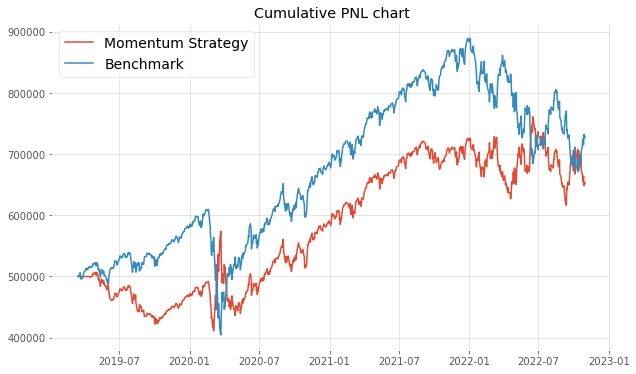


Total Return
Return: Portfolio
Period return YTD: -9.720316651849437%
Period return 1y: -5.8766769494351%
Period return 3y: 48.535608630154%
Period return 2021: 22.721228843609232%
Period return 2020: 26.694074851581174%
Period return 2019: -6.445920069072264%

Return: Benchmark
Period return YTD: -17.951621306427935%
Period return 1y: -14.458427775285543%
Period return 3y: 33.24954606308075%
Period return 2021: 29.38279900213128%
Period return 2020: 18.61910401093798%
Period return 2019: 16.06999024689133%

Annualized Return
Period return All-time: 7.636461216094403%
Period return 3y: 8.234599887257875%

Period return All-time: 10.853622433192944%
Period return 3y: 5.909068336250534%

Stress Tests
Stressed period return during Inflation22: 0.07420647753415555%
Stressed period return during Covid19: -5.305864441890584%

Stressed period return during Inflation22: -12.488769751131024%
Stressed period return during Covid19: -24.30263686368692%



In [1590]:
backtest(mom_ret,spy_ret,500000,'Momentum Strategy')

### Max Sharpe Optimised Momentum Strategy Results

> We find that it is indeed helpful to tune the strategy hyperparameters to achieve max sharpe, as in the backtest results on the test set.

* Lower sharpe than benchmark
* Lower drawdowns than benchmark
* Might be prone to overfitting and may not adapt to market regime shifts

> **Overall the strategy was able to avoid large drawdowns, although the sharpe ratio is lower than benchmark. The performance will also be eroded from the introduction of slippage and commission fees.**

> `Potential improvements: Using a rolling-window Sharpe optimisation with semi-annual rebalancing.`

<a id="meanreversion"></a>
### Mean-Reversion Strategy

In [1547]:
def Drawdowns(RSIdf, drawdown_col):  
    
    index = RSIdf[RSIdf[drawdown_col] == 0].index  

    a = []  

    for i in range(1,len(index)):  
        period = index[i].to_pydatetime() - index[i-1].to_pydatetime()  
        max_drawdown = RSIdf.loc[index[i-1]:index[i], drawdown_col].max()  
        a.append([period,max_drawdown,index[i-1],index[i]])  
    
    df1 = pd.DataFrame(a,columns=['Period','Max Drawdown','Beginning','End']).sort_values('Max Drawdown',ascending=False)  

    return df1.head(1)

# constructing dataframe with mean reversion strategy

def check_individual(df, window_period, threshold):

    df[f"SMA_{window_period}"] = df["Adj Close"].rolling(window = window_period).mean()
    df["DIST"] = df["Adj Close"] - df[f"SMA_{window_period}"]

    df = df.dropna()

    ## buy and sell signals
    df["POS"] = np.where(df["DIST"] > threshold, -1 , np.nan)
    df["POS"] = np.where(df["DIST"] < -threshold, 1, df["POS"])
    df["POS"] = np.where(df["DIST"] * df["DIST"].shift(1) < 0, 0, df["POS"])
    df["POS"] = df["POS"].ffill().fillna(0)


    ## NO. TRADING OPPORTUNITIES
    df["POS_L1"]=df["POS"].shift(1)
    trade_opp = sum(list((df["POS_L1"]!=df["POS"])&(df["POS"]!=0)))

    ## SPY RETURNS
    df["RETURNS"] = np.log(df["Adj Close"]/df["Adj Close"].shift(1)).fillna(0)
    df["CUMULATIVE_SPY_RETURNS"] = df["RETURNS"].cumsum().apply(np.exp)

    ## STRATEGY RETURNS
    df["STRATEGY"] = (df["POS"].shift(1) * df["RETURNS"]).fillna(0)
    df["CUMULATIVE_STRAT_RETURNS"] = df["STRATEGY"].cumsum().apply(np.exp)

    ## SHARPE
    strat_sharpe = np.sqrt(252)*df["STRATEGY"].mean()/df["STRATEGY"].std()

    strat_cagr = (df.iloc[-1]["CUMULATIVE_STRAT_RETURNS"])**(1/((df.index[-1].to_pydatetime()-df.index[1].to_pydatetime()).days/252))-1

    ## MAX DD
    df["MAX_GROSS_PERFORMANCE"] = df["CUMULATIVE_STRAT_RETURNS"].cummax()
    df['DRAWDOWN'] = (df['MAX_GROSS_PERFORMANCE'] - df["CUMULATIVE_STRAT_RETURNS"]) / df['MAX_GROSS_PERFORMANCE']
    
    return df

def window_threshold_loop (df, aclose_column, window_st, window_en, threshold_st, threshold_en):
    
    # collect values from loop
    index_ = []
    spy_c_rtns_ = []
    strat_c_rtns_ = []
    trading_opp_ = []
    strat_sharpe_ = []
    strat_cagr_ = []
    spy_cagr_ = []
    drawdown_ = []
    
    for window_period in range(window_st, window_en):
        for threshold in range(threshold_st, threshold_en):

            index_.append([window_period,threshold])

            df[f"SMA_{window_period}"] = df[[aclose_column]].rolling(window = window_period).mean()
            df["DIST"] = df[aclose_column] - df[f"SMA_{window_period}"]

            ## buy and sell signals
            df["POS"] = np.where(df["DIST"] > threshold, -1 , np.nan)
            df["POS"] = np.where(df["DIST"] < -threshold, 1, df["POS"])
            df["POS"] = np.where(df["DIST"] * df["DIST"].shift(1) < 0, 0, df["POS"])
            df["POS"] = df["POS"].ffill().fillna(0)

            ## NO. TRADING OPPORTUNITIES
            df["POS_L1"]=df["POS"].shift(1)
            trade_opp = sum(list((df["POS_L1"]!=df["POS"])&(df["POS"]!=0)))
            trading_opp_.append(trade_opp)

            ## SPY RETURNS
            df["RETURNS"] = np.log(df[[aclose_column]]/df[[aclose_column]].shift(1)).fillna(0)
            df["CUMULATIVE_SPY_RETURNS"] = df["RETURNS"].cumsum().apply(np.exp)
            spy_c_rtns_.append(df["CUMULATIVE_SPY_RETURNS"].iloc[-1])

            ## STRATEGY RETURNS
            df["STRATEGY"] = (df["POS"].shift(1) * df["RETURNS"]).fillna(0)
            df["CUMULATIVE_STRAT_RETURNS"] = df["STRATEGY"].cumsum().apply(np.exp)
            strat_c_rtns_.append(df["CUMULATIVE_STRAT_RETURNS"].iloc[-1])

            ## SHARPE
            strat_ret = df['STRATEGY'].apply(np.exp) - 1
            strat_sharpe = np.sqrt(252)*strat_ret.mean()/strat_ret.std()
            strat_sharpe_.append(strat_sharpe)

            ### CAGR
            strat_cagr = (df.iloc[-1]["CUMULATIVE_STRAT_RETURNS"])**(1/((df.index[-1].to_pydatetime()-df.index[1].to_pydatetime()).days/365.25))-1
            strat_cagr_.append(strat_cagr)
            
            spy_cagr = (df.iloc[-1]["CUMULATIVE_SPY_RETURNS"])**(1/((df.index[-1].to_pydatetime()-df.index[1].to_pydatetime()).days/365.25))-1
            spy_cagr_.append(spy_cagr)

            ## MAX DD
            df["MAX_GROSS_PERFORMANCE"] = df["CUMULATIVE_STRAT_RETURNS"].cummax()
            df['DRAWDOWN'] = (df['MAX_GROSS_PERFORMANCE'] - df["CUMULATIVE_STRAT_RETURNS"]) / df['MAX_GROSS_PERFORMANCE']
            drawdown_.append(Drawdowns(df, 'DRAWDOWN'))
            
            
    ## put results into a dataframe
    results = pd.DataFrame(index_)
    results.columns = ['window','threshold']

    results['spy_c_rtns'] = spy_c_rtns_
    results['strat_c_rtns'] = strat_c_rtns_
    results['trading_opp'] = trading_opp_
    results['strat_sharpe'] = strat_sharpe_
    results['strat_cagr'] = strat_cagr_
    results['spy_cagr'] = spy_cagr_

    dd_1 = pd.concat(drawdown_, axis=0).reset_index(drop='index')
    results = pd.merge(results, dd_1, left_index=True, right_index=True)
    results['Period'] = results['Period'].apply(lambda x: x.days)
            
            
    return results

In [1542]:
def MV_std_dev_check_indie(df, price_column, window_period, threshold):

    ## SETTING UP DATA
    df[f"SMA_{window_period}_mean"] = df[price_column].rolling(window = window_period).mean()
    df[f"SMA_{window_period}_std"] = df[price_column].rolling(window = window_period).std()
    df[f"SMA_{window_period}_std_x{threshold}"] = df[f"SMA_{window_period}_std"]*threshold
    df['LOWER_T'] = df[f"SMA_{window_period}_mean"] - df[f"SMA_{window_period}_std_x{threshold}"]
    df['HIGHER_T'] = df[f"SMA_{window_period}_mean"] + df[f"SMA_{window_period}_std_x{threshold}"]

    df = df.dropna()

    ## BUY AND SELL SIGNALS
    df["POS"] = np.where(df[price_column] > df["HIGHER_T"], -1, np.nan)
    df["POS"] = np.where(df[price_column] < df["LOWER_T"], 1, df["POS"])
    df["POS"] = df["POS"].ffill().fillna(0)
    
    
    ## NO. TRADING OPPORTUNITIES
    df["POS_L1"]=df["POS"].shift(1)
    trade_opp = sum(list((df["POS_L1"]!=df["POS"])&(df["POS"]!=0)))

    ## price_col RETURNS
    df["RETURNS"] = np.log(df[price_column]/df[price_column].shift(1)).fillna(0)
    df["CUMULATIVE_SPY_RETURNS"] = df["RETURNS"].cumsum().apply(np.exp)

    ## STRATEGY RETURNS
    df["STRATEGY"] = (df["POS"].shift(1) * df["RETURNS"]).fillna(0)
    df["CUMULATIVE_STRAT_RETURNS"] = df["STRATEGY"].cumsum().apply(np.exp)


    ## MAX DD
    df["MAX_GROSS_PERFORMANCE"] = df["CUMULATIVE_STRAT_RETURNS"].cummax()
    df['DRAWDOWN'] = df['MAX_GROSS_PERFORMANCE'] - df["CUMULATIVE_STRAT_RETURNS"]
    
    return df

def rolling_mr_std_loop (df, price_column, window_st, window_en, threshold_st, threshold_en, threshold_step):
    
    # collect values from loop
    index_ = []
    spy_c_rtns_ = []
    strat_c_rtns_ = []
    trading_opp_ = []
    df_sharpe_ = []
    strat_sharpe_ = []
    strat_cagr_ = []
    spy_cagr_ = []
    drawdown_ = []

    for window_period in range(window_st, window_en):
        for threshold in np.arange(threshold_st, threshold_en, threshold_step):

            index_.append([window_period,threshold])
            
            ## SETTING UP DATA
            df[f"SMA_{window_period}_mean"] = df[price_column].rolling(window = window_period).mean()
            df[f"SMA_{window_period}_std"] = df[price_column].rolling(window = window_period).std()
            df[f"SMA_{window_period}_std_x{threshold}"] = df[f"SMA_{window_period}_std"]*threshold
            df['LOWER_T'] = df[f"SMA_{window_period}_mean"] - df[f"SMA_{window_period}_std_x{threshold}"]
            df['HIGHER_T'] = df[f"SMA_{window_period}_mean"] + df[f"SMA_{window_period}_std_x{threshold}"]

            ## BUY AND SELL SIGNALS
            df["POS"] = np.where(df[price_column] > df["HIGHER_T"], -1, np.nan)
            df["POS"] = np.where(df[price_column] < df["LOWER_T"], 1, df["POS"])
            df["POS"] = df["POS"].ffill().fillna(0)

            ## NO. TRADING OPPORTUNITIES
            df["POS_L1"]=df["POS"].shift(1)
            trade_opp = sum(list((df["POS_L1"]!=df["POS"])&(df["POS"]!=0)))
            trading_opp_.append(trade_opp)

            ## df RETURNS
            df["RETURNS"] = np.log(df[price_column]/df[price_column].shift(1)).fillna(0)
            df["CUMULATIVE_df_RETURNS"] = df["RETURNS"].cumsum().apply(np.exp)
            spy_c_rtns_.append(df["CUMULATIVE_df_RETURNS"].iloc[-1])


            ## STRATEGY RETURNS

            df["STRATEGY"] = (df["POS"].shift(1) * df["RETURNS"]).fillna(0)
            df["CUMULATIVE_STRAT_RETURNS"] = df["STRATEGY"].cumsum().apply(np.exp)
            strat_c_rtns_.append(df["CUMULATIVE_STRAT_RETURNS"].iloc[-1])


            ## SHARPE
            market_ret = df['RETURNS'].apply(np.exp) - 1
            strat_ret = df['STRATEGY'].apply(np.exp) - 1
            df_sharpe = np.sqrt(252)*market_ret.mean()/market_ret.std()
            strat_sharpe = np.sqrt(252)*strat_ret.mean()/strat_ret.std()

            df_sharpe_.append(df_sharpe)
            strat_sharpe_.append(strat_sharpe)

            ## CAGR
            spy_cagr = (df.iloc[-1]["CUMULATIVE_df_RETURNS"])**(1/((df.index[-1].to_pydatetime()-df.index[1].to_pydatetime()).days/252))-1
            strat_cagr = (df.iloc[-1]["CUMULATIVE_STRAT_RETURNS"])**(1/((df.index[-1].to_pydatetime()-df.index[1].to_pydatetime()).days/252))-1

            spy_cagr_.append(spy_cagr)
            strat_cagr_.append(strat_cagr)

            ## MAX DD
            df["MAX_GROSS_PERFORMANCE"] = df["CUMULATIVE_STRAT_RETURNS"].cummax()
            df['DRAWDOWN'] = df['MAX_GROSS_PERFORMANCE'] - df["CUMULATIVE_STRAT_RETURNS"]
            drawdown_.append(Drawdowns(df, 'DRAWDOWN'))
            


    ## put results into a dataframe
    results = pd.DataFrame(index_)
    results.columns = ['window','threshold']

    results['spy_c_rtns'] = spy_c_rtns_
    results['strat_c_rtns'] = strat_c_rtns_
    results['trading_opp'] = trading_opp_
    results['df_sharpe'] = df_sharpe_
    results['strat_sharpe'] = strat_sharpe_
    results['strat_cagr'] = strat_cagr_
    results['spy_cagr'] = spy_cagr_

    dd_1 = pd.concat(drawdown_, axis=0).reset_index(drop='index')
    results = pd.merge(results, dd_1, left_index=True, right_index=True)
    results['Period'] = results['Period'].apply(lambda x: x.days)
    
    return results

In [1472]:
# create mean reversion train and test sets
mean_reversion_train = train_set.copy()
mean_reversion_test = test_set.copy()

> We tune the strategy hyperparameters to achieve best sharpe

In [1561]:
# testing from window 20 to 50 and threshold
window_threshold_loop(df=mean_reversion_train, aclose_column="Adj Close", window_st=20, window_en=100, threshold_st=1, threshold_en=5).sort_values('strat_sharpe',ascending=False).iloc[0]


window                           22
threshold                         1
spy_c_rtns                  3.31841
strat_c_rtns               2.147326
trading_opp                     256
strat_sharpe               0.384625
strat_cagr                 0.051571
spy_cagr                   0.082123
Period                         1178
Max Drawdown               0.335098
Beginning       2008-09-08 00:00:00
End             2011-11-30 00:00:00
Name: 8, dtype: object

In [1549]:
# preparing the strategy with tuned hyperparameters
mean_reversion_strat = check_individual(mean_reversion_test.copy()[['Adj Close']], window_period=22, threshold=1)
mean_reversion_strat

,Adj Close,SMA_22,DIST,POS,POS_L1,RETURNS,CUMULATIVE_SPY_RETURNS,STRATEGY,CUMULATIVE_STRAT_RETURNS,MAX_GROSS_PERFORMANCE,DRAWDOWN
Date,,,,,,,,,,,
2019-02-14,257.881256,251.781944,6.099312,-1.0,NaN,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
2019-02-15,260.691467,252.509060,8.182407,-1.0,-1.0,0.010838,1.010897,-0.010838,0.989220,1.000000,0.010780
2019-02-19,261.142609,253.229770,7.912839,-1.0,-1.0,0.001729,1.012647,-0.001729,0.987511,1.000000,0.012489
2019-02-20,261.668976,253.889816,7.779160,-1.0,-1.0,0.002014,1.014688,-0.002014,0.985525,1.000000,0.014475
2019-02-21,260.738495,254.358041,6.380454,-1.0,-1.0,-0.003562,1.011080,0.003562,0.989042,1.000000,0.010958
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,384.920013,367.441365,17.478649,-1.0,-1.0,0.015842,1.492625,-0.015842,0.633490,1.012177,0.374131
2022-10-26,382.019989,368.246364,13.773625,-1.0,-1.0,-0.007563,1.481379,0.007563,0.638299,1.012177,0.369380
2022-10-27,379.980011,369.000910,10.979101,-1.0,-1.0,-0.005354,1.473469,0.005354,0.641726,1.012177,0.365995


In [1550]:
# convert log returns to simple returns
mean_reversion_ret = (mean_reversion_strat['STRATEGY'].apply(np.exp) - 1)
meanrev_ret = pd.merge(spy_ret, pd.DataFrame(mean_reversion_ret),how='left',on='Date').fillna(0)['STRATEGY']
meanrev_ret

Date
2019-03-15   -0.004916
2019-03-18   -0.003613
2019-03-19   -0.000248
2019-03-20    0.003019
2019-03-21   -0.011168
                ...   
2022-10-25   -0.015718
2022-10-26    0.007591
2022-10-27    0.005369
2022-10-28   -0.023238
2022-10-31    0.007276
Name: STRATEGY, Length: 916, dtype: float64

In [1543]:
# tune hyperparameters for rolling standard deviation 
rolling_mr_std_loop(df=mean_reversion_train, price_column="Adj Close", window_st=20, window_en=50, threshold_st=1, threshold_en=3, threshold_step=0.5).sort_values('strat_sharpe',ascending=False).iloc[0]

window                           27
threshold                       2.0
spy_c_rtns                  3.31841
strat_c_rtns               3.486747
trading_opp                      66
df_sharpe                  0.524776
strat_sharpe               0.542357
strat_cagr                 0.058338
spy_cagr                   0.055963
Period                          585
Max Drawdown               0.711218
Beginning       2007-12-10 00:00:00
End             2009-07-17 00:00:00
Name: 30, dtype: object

In [1544]:
mean_reversion_strat2 = MV_std_dev_check_indie(mean_reversion_test.copy(), 'Adj Close', window_period=27, threshold=2)
mean_reversion_strat2

,Adj Close,SMA_20,DIST,POS,POS_L1,RETURNS,CUMULATIVE_SPY_RETURNS,STRATEGY,CUMULATIVE_STRAT_RETURNS,MAX_GROSS_PERFORMANCE,...,SMA_45,SMA_46,SMA_47,SMA_48,SMA_49,SMA_27_mean,SMA_27_std,SMA_27_std_x2,LOWER_T,HIGHER_T
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-26,265.379730,263.426405,7.429446,0.0,NaN,0.000000,1.000000,0.000000,1.000000,1.000000,...,258.933256,258.748566,258.501745,258.226438,257.950284,262.976339,2.442046,4.884092,258.092247,267.860430
2019-03-27,263.992126,263.505438,5.648022,0.0,0.0,-0.005242,0.994771,-0.000000,1.000000,1.000000,...,259.309659,259.043231,258.860131,258.616128,258.344105,263.098585,2.405610,4.811220,258.287365,267.909806
2019-03-28,264.992676,263.658939,6.246414,0.0,0.0,0.003783,0.998542,0.000000,1.000000,1.000000,...,259.696809,259.433203,259.169815,258.987892,258.746261,263.241180,2.399308,4.798617,258.442564,268.039797
2019-03-29,266.663635,263.814215,7.519095,0.0,0.0,0.006286,1.004838,0.000000,1.000000,1.000000,...,260.118168,259.848262,259.587042,259.325936,259.144540,263.426168,2.465072,4.930145,258.496023,268.356313
2019-04-01,269.826019,264.175548,10.285796,-1.0,0.0,0.011789,1.016754,0.000000,1.000000,1.000000,...,260.563227,260.329208,260.060554,259.800354,259.540224,263.762743,2.693775,5.387550,258.375193,269.150293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,384.920013,367.801001,0.501318,1.0,1.0,0.015842,1.450450,0.015842,1.556849,1.556849,...,381.186667,381.849108,382.669617,383.575240,384.418696,369.478149,8.871776,17.743551,351.734598,387.221700
2022-10-26,382.019989,368.375500,-1.523511,1.0,1.0,-0.007563,1.439522,-0.007563,1.545119,1.556849,...,380.550154,381.204783,381.852744,382.656083,383.543500,369.236298,8.408791,16.817582,352.418716,386.053879
2022-10-27,379.980011,369.235001,-2.621459,1.0,1.0,-0.005354,1.431835,-0.005354,1.536869,1.556849,...,379.839094,380.537760,381.178724,381.813729,382.601470,369.084076,8.163171,16.326341,352.757735,385.410417


In [1545]:
# convert log returns to simple returns
mean_reversion_ret2 = (mean_reversion_strat2['STRATEGY'].apply(np.exp) - 1)
meanrev_ret2 = pd.merge(spy_ret, pd.DataFrame(mean_reversion_ret2),how='left',on='Date').fillna(0)['STRATEGY']
meanrev_ret2

Date
2019-03-15    0.000000
2019-03-18    0.000000
2019-03-19    0.000000
2019-03-20    0.000000
2019-03-21    0.000000
                ...   
2022-10-25    0.015969
2022-10-26   -0.007534
2022-10-27   -0.005340
2022-10-28    0.023791
2022-10-31    0.007276
Name: STRATEGY, Length: 916, dtype: float64


Performance Statistics for Mean Reversion
Daily annualized sharpe: -0.4733831028606834
Daily annualized sortino: -0.5924141798847805
Average annual returns: -10.39541848542138%
Total cumulative returns: 62.750549055993865%
Max drawdown: -40.55750953342652%


Performance Statistics for Benchmark
Daily annualized sharpe: 0.5659580065880667
Daily annualized sortino: 0.6715174318766671
Average annual returns: 12.936387989045084%
Total cumulative returns: 145.4327768112515%
Max drawdown: -33.717206670764746%



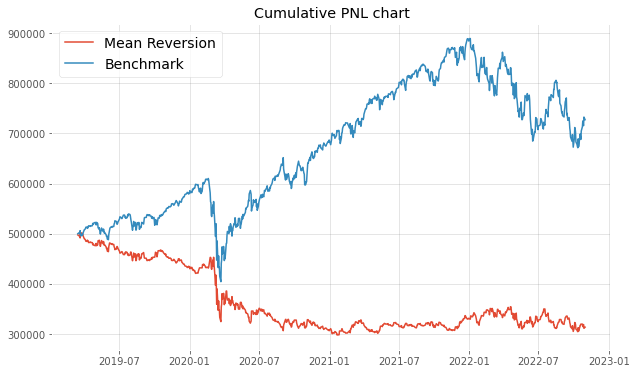


Total Return
Return: Portfolio
Period return YTD: -5.121991189153596%
Period return 1y: -0.2890673298639679%
Period return 3y: -31.500237342082627%
Period return 2021: 7.604954875464709%
Period return 2020: -29.562474341591937%
Period return 2019: -13.172605196856924%

Return: Benchmark
Period return YTD: -17.951621306427935%
Period return 1y: -14.458427775285543%
Period return 3y: 33.24954606308075%
Period return 2021: 29.38279900213128%
Period return 2020: 18.61910401093798%
Period return 2019: 16.06999024689133%

Annualized Return
Period return All-time: -12.03240338968431%
Period return 3y: -7.287602186674014%

Period return All-time: 10.853622433192944%
Period return 3y: 5.909068336250534%

Stress Tests
Stressed period return during Inflation22: -12.488769751131024%
Stressed period return during Covid19: -24.30263686368692%

Stressed period return during Inflation22: -12.488769751131024%
Stressed period return during Covid19: -24.30263686368692%



In [1591]:
backtest(meanrev_ret, spy_ret, 500000, 'Mean Reversion')


Performance Statistics for Mean Reversion Rolling SD
Daily annualized sharpe: 0.6686935876813829
Daily annualized sortino: 0.8898278440418721
Average annual returns: 15.295696940474546%
Total cumulative returns: 158.48797047726893%
Max drawdown: -28.31899141965042%


Performance Statistics for Benchmark
Daily annualized sharpe: 0.5659580065880667
Daily annualized sortino: 0.6715174318766671
Average annual returns: 12.936387989045084%
Total cumulative returns: 145.4327768112515%
Max drawdown: -33.717206670764746%



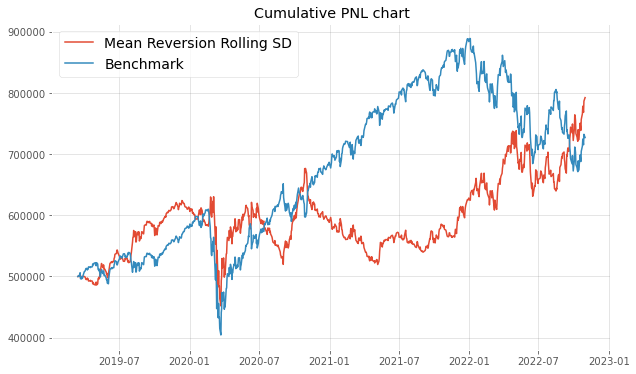


Total Return
Return: Portfolio
Period return YTD: 26.46294847106645%
Period return 1y: 37.09535413978908%
Period return 3y: 32.37761838697537%
Period return 2021: 6.207314353168147%
Period return 2020: -4.074588382081501%
Period return 2019: 22.40130996465637%

Return: Benchmark
Period return YTD: -17.951621306427935%
Period return 1y: -14.458427775285543%
Period return 3y: 33.24954606308075%
Period return 2021: 29.38279900213128%
Period return 2020: 18.61910401093798%
Period return 2019: 16.06999024689133%

Annualized Return
Period return All-time: 13.506522207592253%
Period return 3y: 5.770099446060262%

Period return All-time: 10.853622433192944%
Period return 3y: 5.909068336250534%

Stress Tests
Stressed period return during Inflation22: -4.509289052635346%
Stressed period return during Covid19: -24.30263686368692%

Stressed period return during Inflation22: -12.488769751131024%
Stressed period return during Covid19: -24.30263686368692%



In [1592]:
backtest(meanrev_ret2, spy_ret, 500000, 'Mean Reversion Rolling SD')

### Mean Reversion Strategy Results

> Max Sharpe Optimised Mean reversion strategy

* The strategy was not able to outperform the benchmark. 
* Poor sharpe ratio with equally high drawdowns
* Does not perform well during historical stress scenarios
* Might be prone to overfitting and may not adapt to market regime shift

> Max Sharpe Optimised Mean reversion strategy with rolling standard deviation

* The strategy was able to outperform the benchmark
* Better sharpe and lower drawdowns
* Compound annual growth rate is higher than benchmark
* Lower drawdowns during historical stress scenarios
* Might be prone to overfitting (although less prone than vanilla) and may not adapt quickly to market regime shift

> `Potential improvements: Rolling window sharpe optimisation with semi-annual rebalancing`

<a id="ml"></a>
### Machine Learning Strategy

> We first determine what are the potential features that could possibly be included into the ML model, which has to have some sort of economic intuition behind the inclusion. After determining the features, we try to collect historical data on them. 

> In real-world practice, it is important that data integrity is not compromised. We can do this by collecting data from multiple sources. There is also the case where by data is not available in 1 source,and in our case, we collected data from 3 sources:
    
* YahooFinance
* FRED
* Bloomberg Terminal

Bloomberg data was included via CSV, as API access is only available to Bloomberg Enterprise subscribers.

> `We included the below features:`

* Currency: USDJPY, USDGBP, USDEUR, USDCNY, US Dollar Index (DXY) -> Major currencies associated with SP500 company worldwide earnings
* US and Global Stock Indices: VIX, Nasdaq Composite, Dow Jones, Russell 2000, Hang Seng, Nikkei, SSE Composite, STI, AS30 All Ordinaries, UKX, DAX, CAC 40
* Commodity: Gold, Silver, Oil, Natural Gas Generic 1st Future Contracts
* Rates: Fed Fund Futures
* Technical Indicators

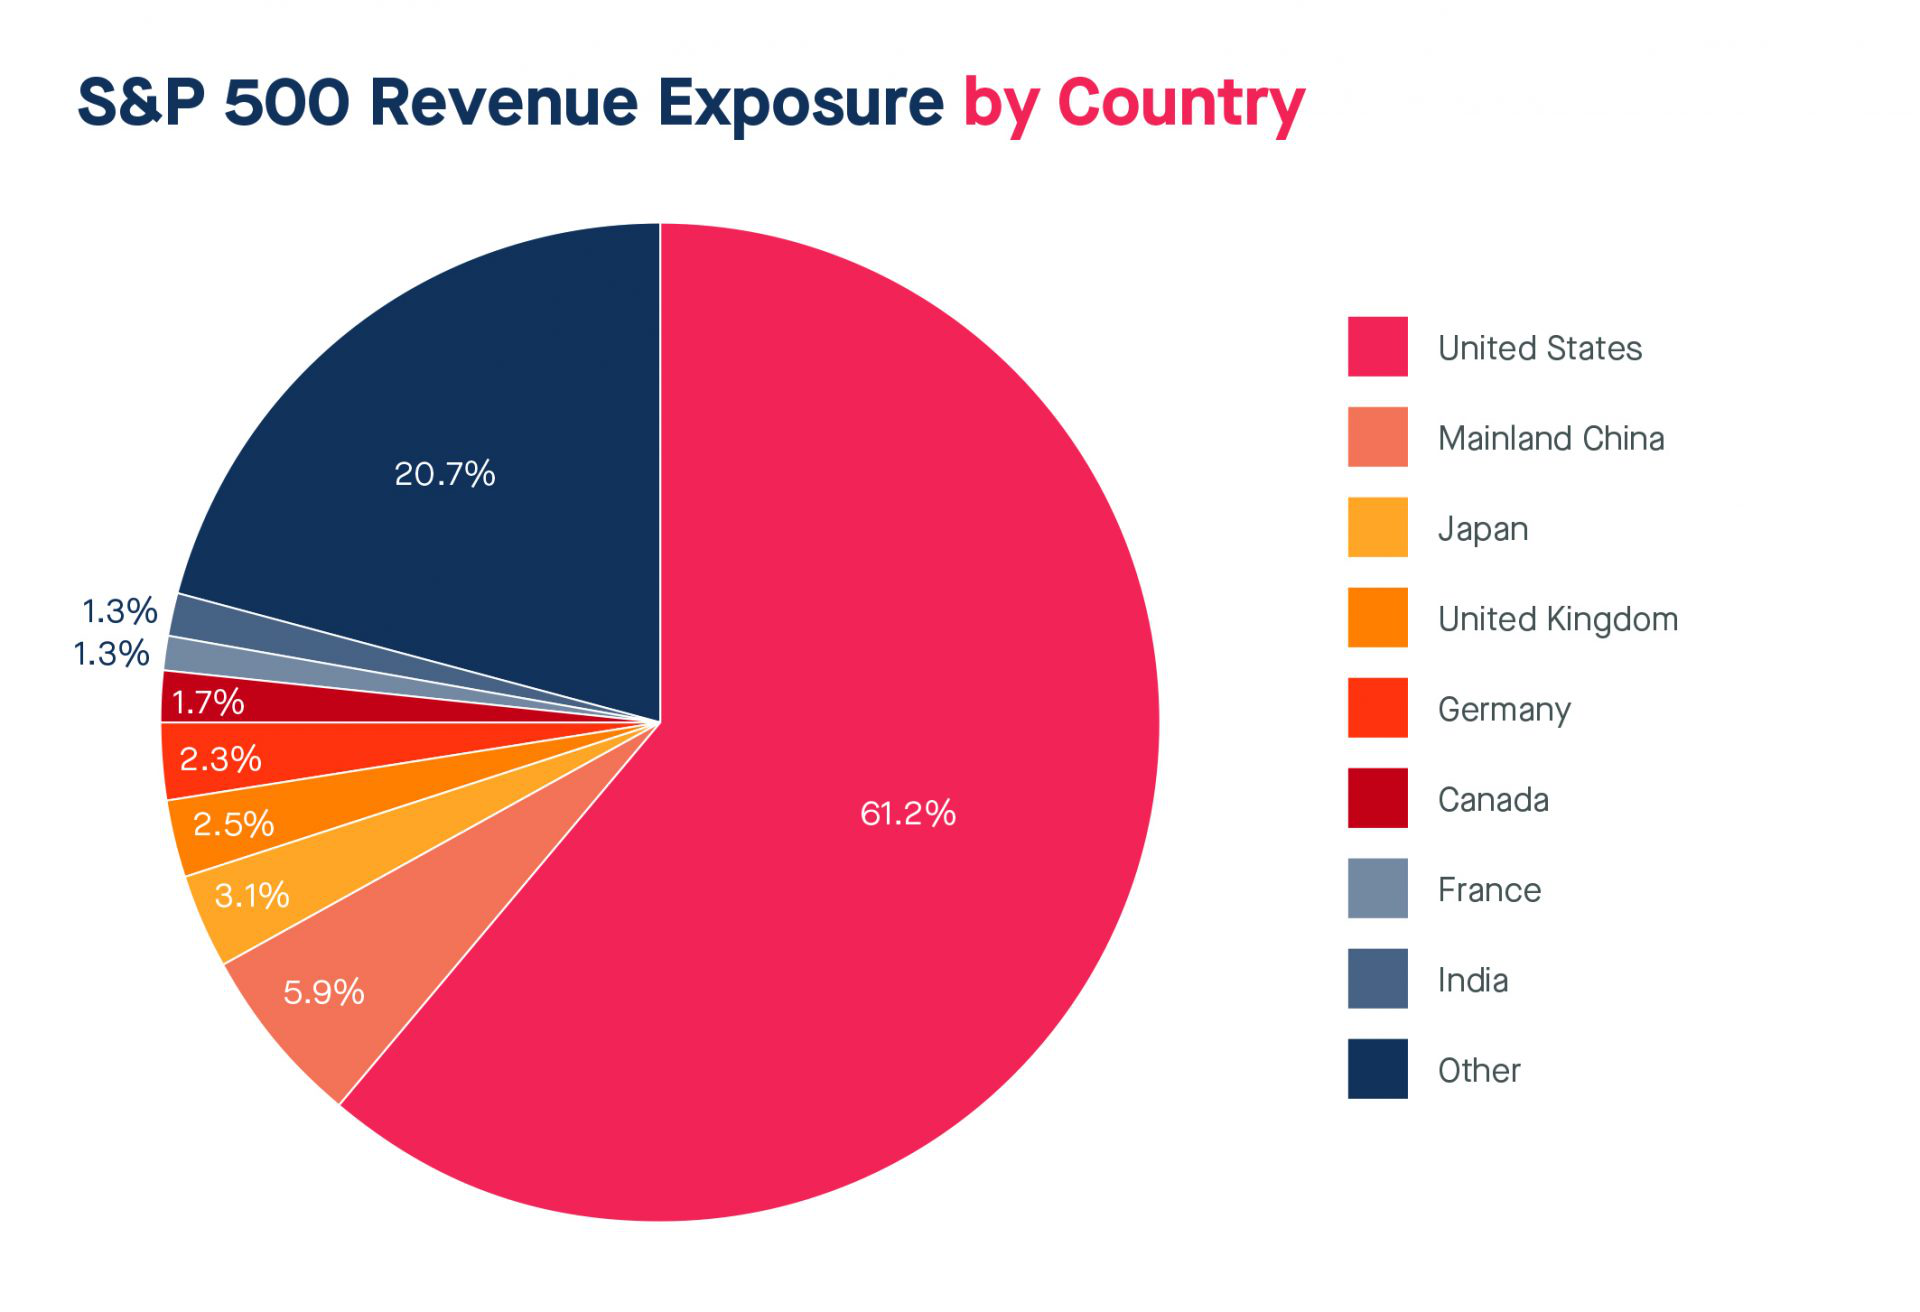

In [1498]:
from PIL import Image

Image.open("SP500_revenue_exposure.jpg")

In [902]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

start = dt.datetime(2003, 11, 1)
end = dt.datetime(2022, 10, 31)

stock_tickers = ['SPY']
currency_tickers = ['DEXJPUS','DEXUSUK','DEXUSEU','DEXCHUS']
index_tickers = ['NASDAQCOM','VIXCLS']

stock_data = pdr.DataReader(stock_tickers,'yahoo',start=start+dt.timedelta(days=1), end=end)
currency_data = pdr.DataReader(currency_tickers,'fred',start=start, end=end)
index_data = pdr.DataReader(index_tickers,'fred',start=start, end=end)

stock_data.index.names = ['Date']
currency_data.index.names = ['Date']
index_data.index.names = ['Date']

# separate closing prices
stock = pd.DataFrame(stock_data.loc[:, ('Adj Close', 'SPY')])
stock.columns = stock.columns.droplevel()

# import rest of features
currency2_data = pd.read_csv('currency.csv')
index2_data = pd.read_csv('index.csv')
interest_rate_data = pd.read_csv('interest_rate.csv')
commodity_data = pd.read_csv('commodity.csv')

# formatting
currency2_data['Date'] = pd.to_datetime(currency2_data['Date'], format='%d/%m/%Y')
index2_data['Date'] = pd.to_datetime(index2_data['Date'], format='%d/%m/%Y')
interest_rate_data['Date'] = pd.to_datetime(interest_rate_data['Date'], format='%d/%m/%Y')
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'], format='%d/%m/%Y')
currency2_data = currency2_data.set_index('Date')
index2_data = index2_data.set_index('Date')
commodity_data = commodity_data.set_index('Date')
interest_rate_data  = interest_rate_data.set_index('Date')

# merge data
currency_data = pd.merge(currency_data,currency2_data,how='left',on='Date')
index_data = pd.merge(index_data,index2_data,how='left',on='Date')

# main data
main = pd.merge(stock,currency_data,how='left',on='Date')
main = pd.merge(main,index_data,how='left',on='Date')
main = pd.merge(main,commodity_data,how='left',on='Date')
main = pd.merge(main,interest_rate_data,how='left',on='Date')
main = main.fillna(method='ffill')

> We look at the correlation of SPY with major global stock indices, and why we include them as features into the ML algorithms

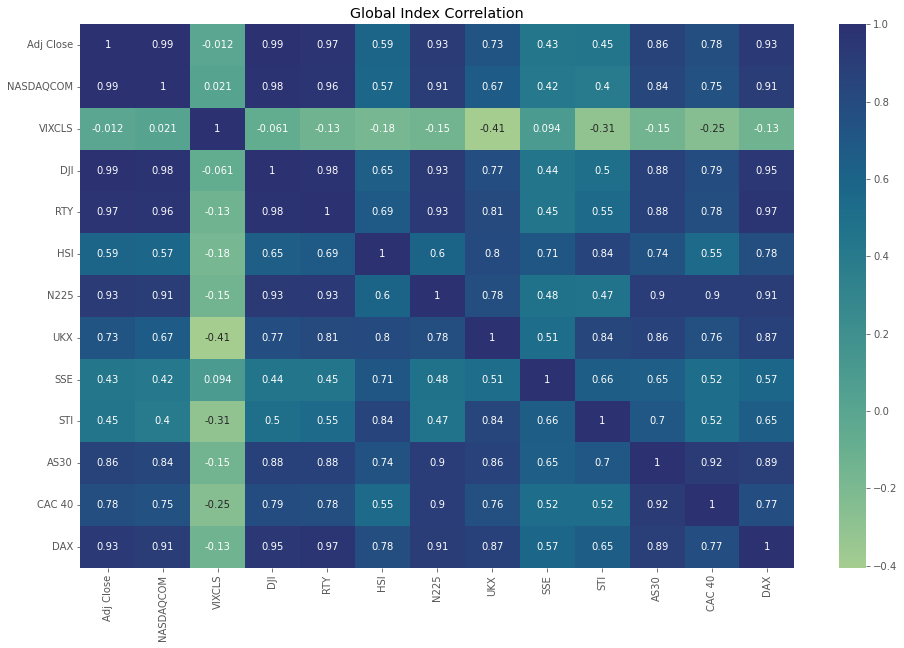

In [1511]:
index_corr = pd.merge(SPY,index_data,how='left',on='Date').fillna(method='ffill').dropna().corr()
plt.figure(figsize=(16,10))
plt.title('Global Index Correlation')
sns.heatmap(index_corr,annot=True, cmap='crest')
plt.show()

In [105]:
def MA(df, n):
    MA = pd.Series(df.rolling(n, min_periods=n).mean(), name="MA_" + str(n))
    return MA

# Exponential Moving Average

def EMA(df, n):
    EMA = pd.Series(df.ewm(span = n,
                                    min_periods = n).mean(),
                    name = "EMA_" + str(n)
                    )
    return EMA

# Price Momentum

def MOM(df, n):
    MOM = pd.Series(df.diff(n),
                    name = "MOM_" + str(n)
                   )
    return MOM

# Stochastic Oscillator 

def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    
    STOD = STOK.rolling(3).mean()
    return STOD

# Rate of Change (RoC)

def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series((M / N) * 100, 
                    name = "ROC_" + str(n)    
                    )
    return ROC

# RSI 
def RSI(series, period): 
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)])
    
    d[d.index[period - 1]] = np.mean(d[:period])
    
    d = d.drop(d.index[:(period - 1)])
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

In [903]:
SPY = main['SPY']
main = np.log(main/main.shift(1))
main = main.rename(columns={'SPY':'RETURNS'})
main.insert(0, 'Adj Close', SPY)
main = main.fillna(0)
df = pd.DataFrame(stock_data.loc[:, (('Low','High','Open','Volume'), 'SPY')])
df.columns = df.columns.droplevel()
df.columns = ('Low','High','Open','Volume')
main = pd.merge(main,df,on='Date',how='left')
main


,Adj Close,RETURNS,DEXJPUS,DEXUSUK,DEXUSEU,DEXCHUS,DXY,NASDAQCOM,VIXCLS,DJI,...,DAX,GC1,SI1,CL1,NG1,FF1,Low,High,Open,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2003-11-03,73.380783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.709999,106.610001,105.750000,37589300.0
2003-11-04,73.221558,-0.002172,-0.014493,0.000953,0.003747,0.000012,-0.004602,-0.004962,0.000000,-0.001993,...,-0.000745,0.007661,0.020690,-0.005204,0.004665,0.000000,105.580002,106.269997,105.989998,31421600.0
2003-11-05,73.276924,0.000756,0.002824,-0.001310,-0.002090,0.000000,0.004281,0.000720,0.018558,-0.001831,...,-0.006438,0.007080,-0.008987,0.052510,0.035332,0.000000,104.900002,105.970001,105.489998,33558800.0
2003-11-06,73.664650,0.005277,0.002181,-0.005198,-0.004893,0.000024,0.002773,0.008639,-0.007143,0.003673,...,0.004356,-0.005240,-0.005633,-0.001321,-0.050037,0.000000,105.099998,106.440002,105.599998,28392300.0
2003-11-07,73.117699,-0.007453,-0.007838,0.000898,0.007678,0.000012,-0.009309,-0.002853,0.011286,-0.004798,...,0.012940,0.007067,0.020170,0.019310,0.010252,0.000000,105.570000,106.720001,106.639999,31723200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,384.920013,0.015842,-0.006136,0.015288,0.008572,0.000812,-0.009321,0.022257,-0.047685,0.010645,...,0.009353,0.002484,0.008304,0.008711,0.076619,0.000000,378.670013,385.250000,378.790009,78846300.0
2022-10-26,382.019989,-0.007563,-0.009173,0.012650,0.010885,-0.013546,-0.011330,-0.020581,-0.042346,0.000074,...,0.010884,0.006754,0.007056,0.029905,-0.001248,0.000000,381.350006,387.579987,381.619995,104087300.0
2022-10-27,379.980011,-0.005354,-0.003282,-0.003536,-0.008278,0.007350,0.008053,-0.016387,0.004024,0.006080,...,0.001168,-0.001985,0.000410,0.013221,-0.077875,0.000000,379.329987,385.000000,383.070007,81971800.0


### Target Outcome

> Next we determine the Target Outcomes that we want to predict using Supervised Machine learning

* `Target Outcome 1`: Adj Close (T+1) > Adj Close (T): 1 else 0
* `Target Outcome 2`: Open (T+1) > Open (T): 1 else 0

There is merit in using a long only binary classifier strategy, as wrong predictions can be more forgiving. In the case of a wrong prediction for a long-short binary classifier strategy (+1 instead of -1), there will be 2x directional impact, compared to a long-only strategy.

### Technical Indicators

> We also add in standard technical indicators as features.

> `Technical indicators`
* 10-day, 50-day, 200-day simple moving averages
* 10-day, 50-day, 200-day exponential-weighted moving averages
* 10-day, 30-day Rate of Change
* 10-day, 30-day Momentum
* 10-day, 30-day, 200-day Relative Strength Index
* 10-day, 30-day, 200-day rolling window Stochastic Oscillator

In [904]:
# shift signal positions as we want to predict positions
main['signal_1'] = np.where(main['Adj Close'] > main['Adj Close'].shift(1), 1.0, 0.0)
main['signal_1'] = main['signal_1'].shift(-1).fillna(0)
main['signal_2'] = np.where(main['Open'] > main['Open'].shift(1), 1.0, 0.0)
main['signal_2'] = main['signal_2'].shift(-1).fillna(0)
main['MA10'] = MA(main['Adj Close'], 10)
main['MA50'] = MA(main['Adj Close'], 50)
main['MA200'] = MA(main['Adj Close'], 200)
main['EMA10'] = EMA(main['Adj Close'], 10)
main['EMA50'] = EMA(main['Adj Close'], 50)
main['EMA200'] = EMA(main['Adj Close'], 200)
main['ROC10'] = ROC(main['Adj Close'], 10)
main['ROC30'] = ROC(main['Adj Close'], 30)
main['MOM10'] = MOM(main['Adj Close'], 10)
main['MOM30'] = MOM(main['Adj Close'], 30)
main['RSI10'] = RSI(main['Adj Close'], 10)
main['RSI30'] = RSI(main['Adj Close'], 30)
main['RSI200'] = RSI(main['Adj Close'], 200)
main['%K10'] = STOK(main['Adj Close'], main['Low'], main['High'], 10)
main['%D10'] = STOD(main['Adj Close'], main['Low'], main['High'], 10)
main['%K30'] = STOK(main['Adj Close'], main['Low'], main['High'], 30)
main['%D30'] = STOD(main['Adj Close'], main['Low'], main['High'], 30)
main['%K200'] = STOK(main['Adj Close'], main['Low'], main['High'], 200)
main['%D200'] = STOD(main['Adj Close'], main['Low'], main['High'], 200)
main = main.drop(['High','Low'],axis=1)
main

,Adj Close,RETURNS,DEXJPUS,DEXUSUK,DEXUSEU,DEXCHUS,DXY,NASDAQCOM,VIXCLS,DJI,...,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
Date,,,,,,,,,,,,,,,,,,,,,
2003-11-03,73.380783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-04,73.221558,-0.002172,-0.014493,0.000953,0.003747,0.000012,-0.004602,-0.004962,0.000000,-0.001993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-05,73.276924,0.000756,0.002824,-0.001310,-0.002090,0.000000,0.004281,0.000720,0.018558,-0.001831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-06,73.664650,0.005277,0.002181,-0.005198,-0.004893,0.000024,0.002773,0.008639,-0.007143,0.003673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-07,73.117699,-0.007453,-0.007838,0.000898,0.007678,0.000012,-0.009309,-0.002853,0.011286,-0.004798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,384.920013,0.015842,-0.006136,0.015288,0.008572,0.000812,-0.009321,0.022257,-0.047685,0.010645,...,-6.571808,63.211565,50.909193,49.096921,99.111507,97.048018,76.543996,57.877346,29.426829,24.982024
2022-10-26,382.019989,-0.007563,-0.009173,0.012650,0.010885,-0.013546,-0.011330,-0.020581,-0.042346,0.000074,...,-10.965698,59.742628,49.935391,48.926495,85.913359,93.766763,70.867292,67.782909,27.108479,27.041868
2022-10-27,379.980011,-0.005354,-0.003282,-0.003536,-0.008278,0.007350,0.008053,-0.016387,0.004024,0.006080,...,-8.544006,57.285510,49.249861,48.806721,75.179697,86.734854,77.354408,74.921899,25.477671,27.337660


### Data wrangling for prediction and accounting for Forward Bias

> Target Outcome 1: Predicting next day's Adj Close price
* `We need to remove signals that were generated using perfect information, and RETURNS data when trying to predict`

> Target Outcome 2: Predicting next day's Open price
* `We need to remove signals that were generated using perfect information, and RETURNS data when trying to predict`
* `We shift all information that is only available after SPY Open 1 timestamp back. This is important as we cannot use information that does not yet exist at time of position.`
* `Shifted datapoints are US Indices Close, SPY Adj Close, and Technical indicators that rely on High,Low,Close,Volume data. Non-US indices may remain due to different timezones.` 

In [938]:
# X and Y for Target Outcome 1
Y1 = main.dropna(axis=0)['signal_1']
X1 = main.dropna(axis=0).loc[:, (main.columns != 'signal_1') & (main.columns != 'signal_2') & (main.columns != 'RETURNS')]

# X and Y for Target Outcome 2
main2 = main.copy()
main2[['Adj Close','NASDAQCOM','VIXCLS','DJI','RTY','Volume','MA10','MA50','MA200','EMA10','EMA50','EMA200','ROC10','ROC30','MOM10','MOM30','RSI10','RSI30','RSI200','%K10','%D10','%K30','%D30','%K200','%D200']] = main2[['Adj Close','NASDAQCOM','VIXCLS','DJI','RTY','Volume','MA10','MA50','MA200','EMA10','EMA50','EMA200','ROC10','ROC30','MOM10','MOM30','RSI10','RSI30','RSI200','%K10','%D10','%K30','%D30','%K200','%D200']].shift(1)
main2 = main2.dropna(axis=0)
Y2 = main2['signal_2']
X2 = main2.loc[:, (main.columns != 'signal_1') & (main.columns != 'signal_2') & (main.columns != 'RETURNS')]

# for EDA
combined1 = pd.merge(Y1,X1,on='Date',how='left')
combined2 = pd.merge(Y2,X2,on='Date',how='left')

> Distribution plots for Target Outcome 1 Signal & Features

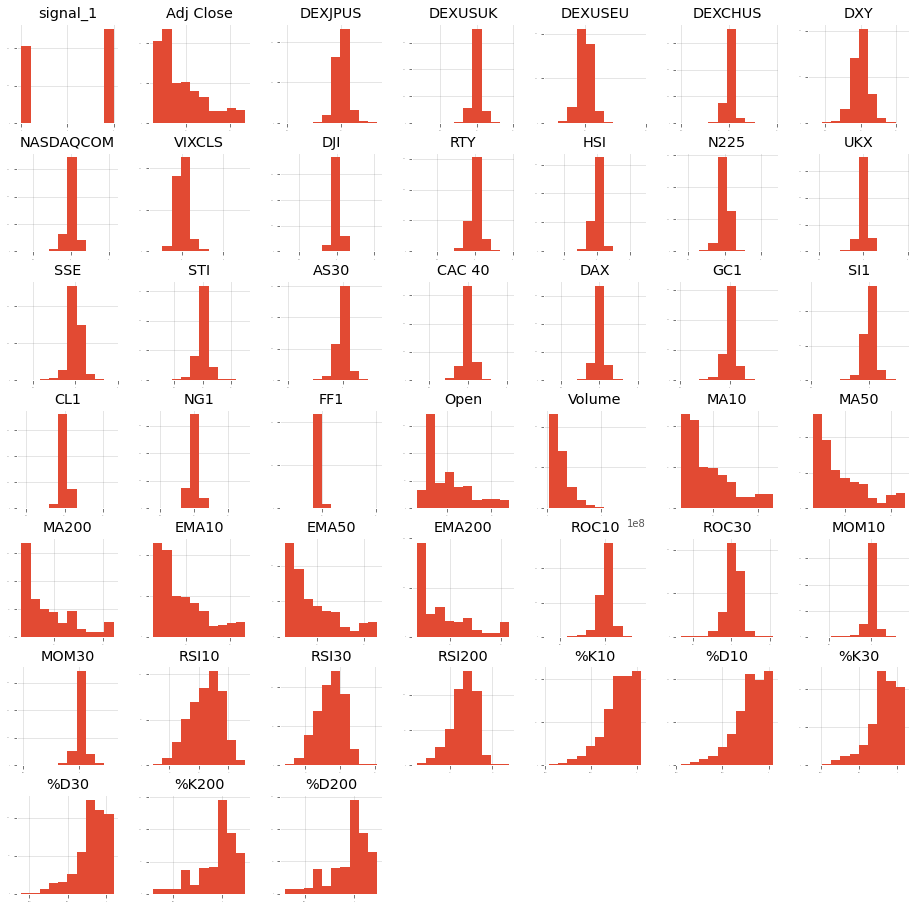

In [1464]:
combined1.hist(sharex = False, sharey = False, xlabelsize = 1, ylabelsize =1, figsize = (16,16))
plt.show()

> Distribution plots for Target Outcome 2 Signal & Features (Adjusted for forward bias)

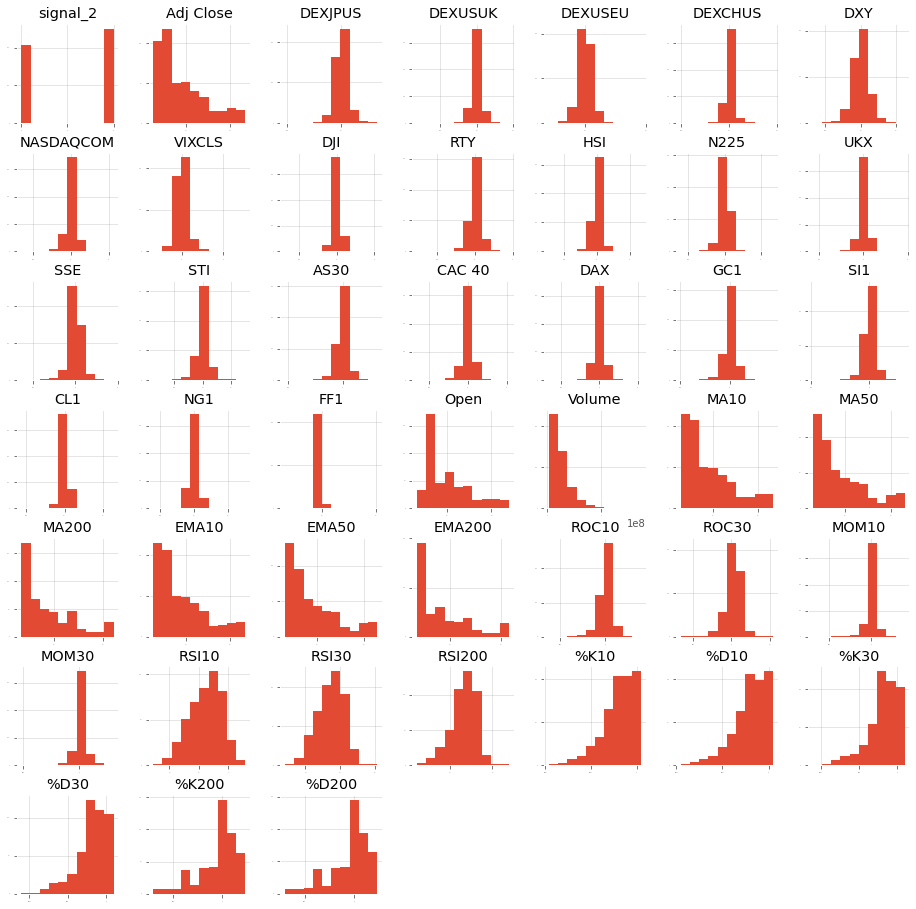

In [1465]:
combined2.hist(sharex = False, sharey = False, xlabelsize = 1, ylabelsize =1, figsize = (16,16))
plt.show()

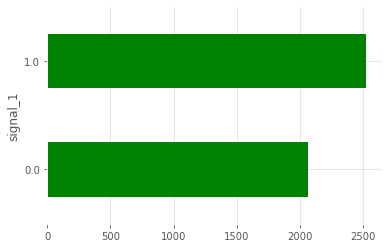

In [1468]:
fig = plt.figure()
plot = combined1.groupby(['signal_1']).size().plot(kind = "barh", color = "green")
plt.show()

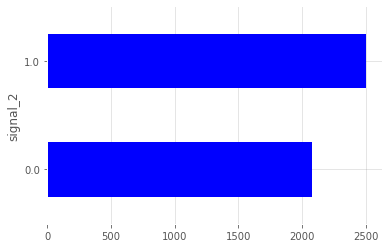

In [1467]:
fig = plt.figure()
plot = combined2.groupby(['signal_2']).size().plot(kind = "barh", color = "blue")
plt.show()

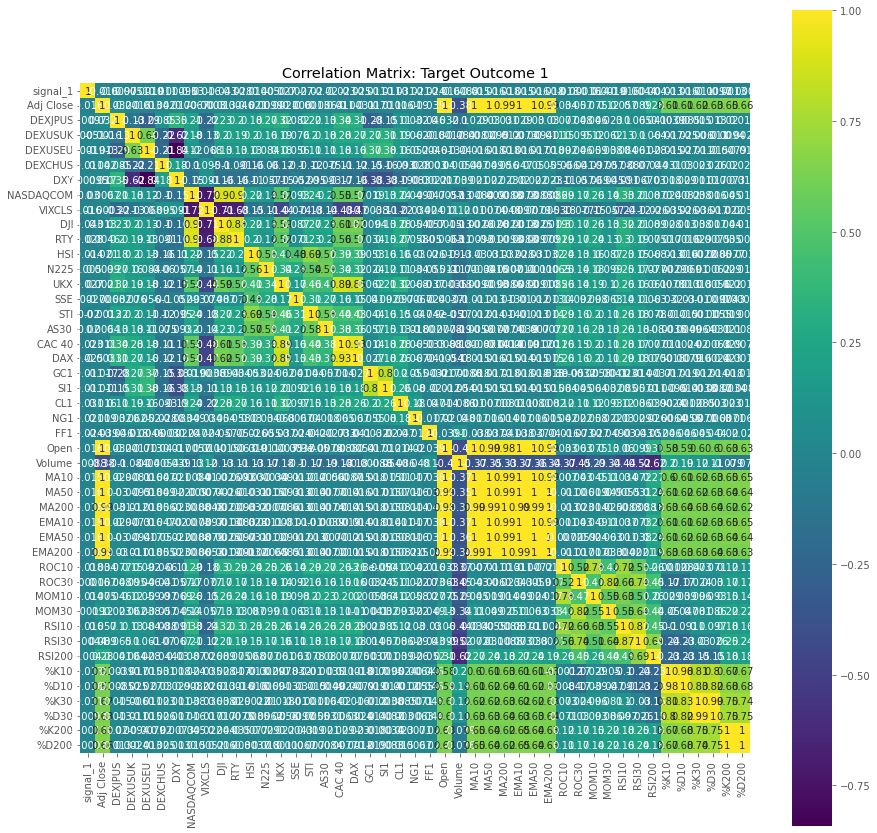

In [1469]:
# Correlation matrix for Target Outcome 1
correlation = combined1.corr()

plt.figure(figsize=(15,15))
plt.title("Correlation Matrix: Target Outcome 1")

sns.heatmap(correlation, 
            vmax = 1, 
            square = True,
            annot = True,
            cmap = "viridis")
plt.show()

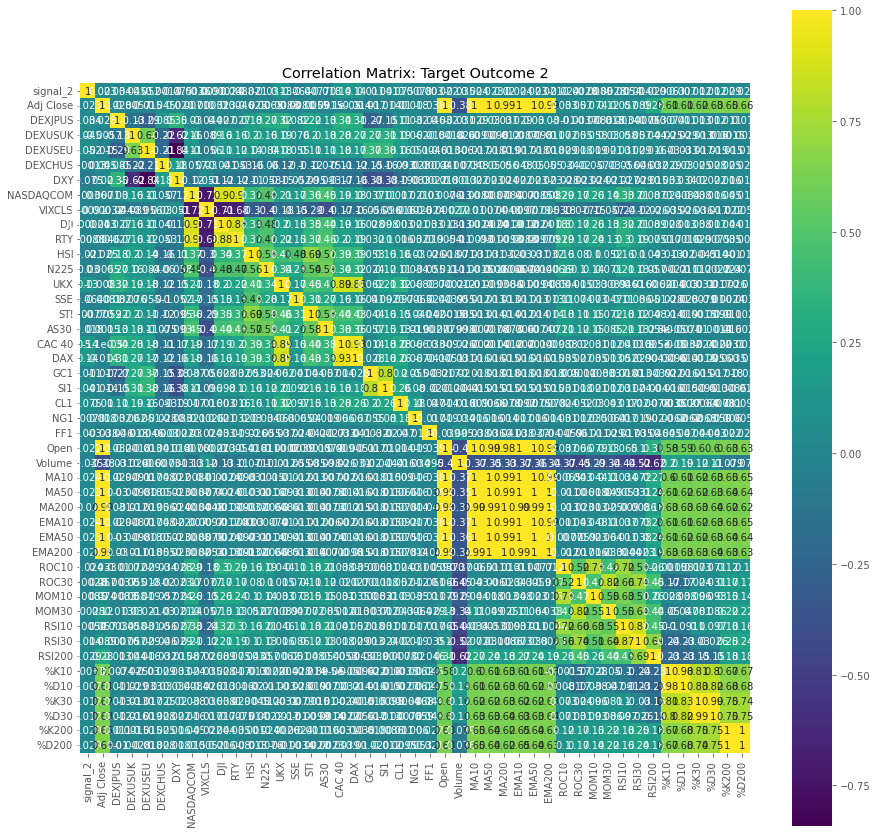

In [1470]:
# Correlation matrix for Target Outcome 2
correlation2 = combined2.corr()

plt.figure(figsize=(15,15))
plt.title("Correlation Matrix: Target Outcome 2")

sns.heatmap(correlation2, 
            vmax = 1, 
            square = True,
            annot = True,
            cmap = "viridis")
plt.show()

In [1198]:
# train-test split for both outcomes
validation_size = 0.20
train_size1 = int(len(X1) * (1 - validation_size))
train_size2 = int(len(X2) * (1 - validation_size))

X_train1, X_test1 = X1[0:train_size1], X1[train_size1:len(X1)]
Y_train1, Y_test1 = Y1[0:train_size1], Y1[train_size1:len(X1)]

X_train2, X_test2 = X2[0:train_size2], X2[train_size2:len(X2)]
Y_train2, Y_test2 = Y2[0:train_size2], Y2[train_size2:len(X2)]

### Model Selection 

We test the efficacy of prediction of 2 target outcomes using established supervised learning algorithms.

* Support Vector Classifier
* Logistic Regression
* K Neighbours Classifier
* Decision Tree Classifier
* Gaussian Naive Bayes
* MLP Classifier
* AdaBoost Classifier
* Gradient Boosting Classifier
* Random Forest Classifier

We try to predict the target outcomes below:

> Target Outcome 1: Predicting next day's Adj Close price

> Target Outcome 2: Predicting next day's Open price


In [1261]:
# model by accuracy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # multi-class

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 10-fold cross validation
num_folds = 10
seed = 1
scoring = "accuracy"

models = []

models.append(("SVC", SVC()))
models.append(("LR", LogisticRegression(n_jobs = -1)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
models.append(("NN", MLPClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
models.append(("RF", RandomForestClassifier(n_jobs = -1)))

results = []
names = []

print('Target Outcome 1:')
for name, model in models:
    kfold = KFold(n_splits = num_folds, 
                  random_state = seed, 
                  shuffle = True)
    cv_results = cross_val_score(model, 
                                 X_train1, 
                                 Y_train1, 
                                 cv = kfold, 
                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Target Outcome 1:
SVC: 0.551852 (0.026220)
LR: 0.551030 (0.025328)
LDA: 0.535483 (0.029262)
KNN: 0.511181 (0.015740)
CART: 0.510927 (0.023765)
NB: 0.550761 (0.022750)
NN: 0.484993 (0.054957)
AB: 0.520732 (0.023982)
GBM: 0.524010 (0.022598)
RF: 0.522383 (0.017295)


In [1262]:
# Target outcome 2
results2 = []
names2 = []

print('Target Outcome 2:')
for name, model in models:
    kfold = KFold(n_splits = num_folds, 
                  random_state = seed, 
                  shuffle = True)
    cv_results = cross_val_score(model, 
                                 X_train2, 
                                 Y_train2, 
                                 cv = kfold, 
                                 scoring = scoring)
    results2.append(cv_results)
    names2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Target Outcome 2:
SVC: 0.536850 (0.020998)
LR: 0.540119 (0.027569)
LDA: 0.583789 (0.018929)
KNN: 0.510639 (0.026928)
CART: 0.520203 (0.023509)
NB: 0.543122 (0.023022)
NN: 0.495394 (0.048399)
AB: 0.552656 (0.022219)
GBM: 0.566318 (0.023310)
RF: 0.560324 (0.026583)


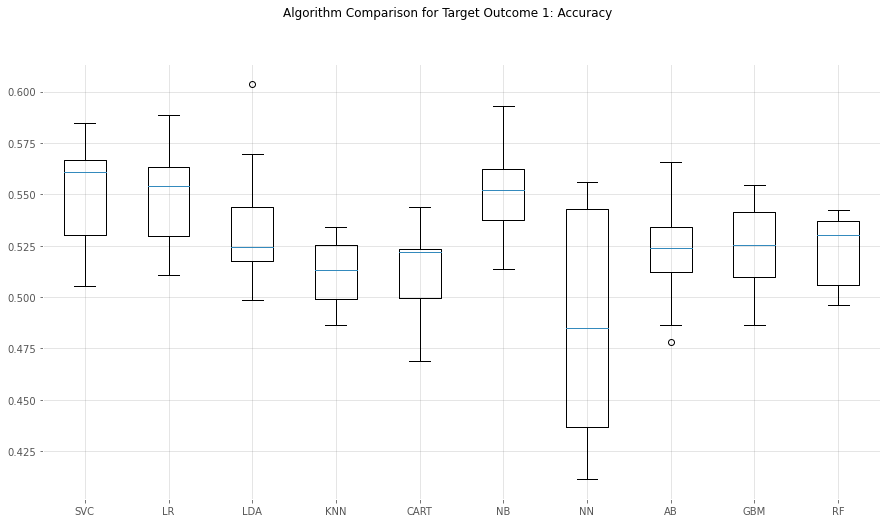

In [1461]:
fig = plt.figure()
fig.suptitle("Algorithm Comparison for Target Outcome 1: Accuracy")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

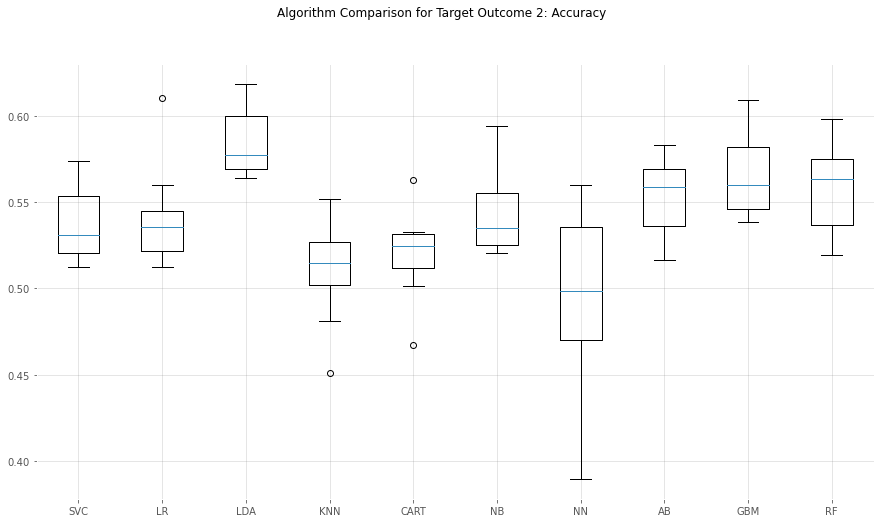

In [1462]:
fig = plt.figure()
fig.suptitle("Algorithm Comparison for Target Outcome 2: Accuracy")
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
fig.set_size_inches(15,8)
plt.show()

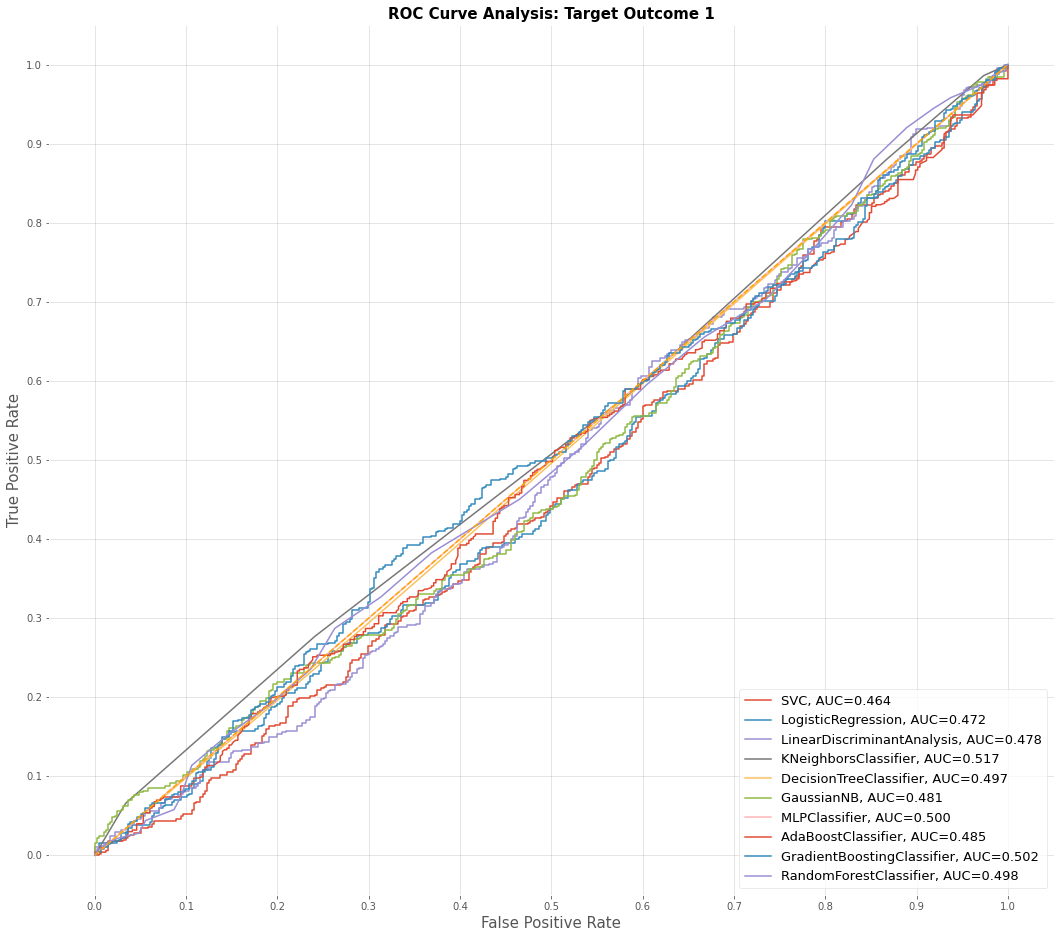

In [1459]:
from sklearn.metrics import roc_curve, roc_auc_score

classifiers = [SVC(probability=True),
            LogisticRegression(n_jobs = -1),
            LinearDiscriminantAnalysis(),  
            KNeighborsClassifier(), 
            DecisionTreeClassifier(),
            GaussianNB(),
            MLPClassifier(),
            AdaBoostClassifier(),
            GradientBoostingClassifier(),
            RandomForestClassifier(n_jobs = -1)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train1, Y_train1)
    yproba = model.predict_proba(X_test1)[::,1]
    
    fpr, tpr, _ = roc_curve(Y_test1,  yproba)
    auc = roc_auc_score(Y_test1, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

# Plot ROC_AUC
fig = plt.figure(figsize=(18,16))
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis: Target Outcome 1', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

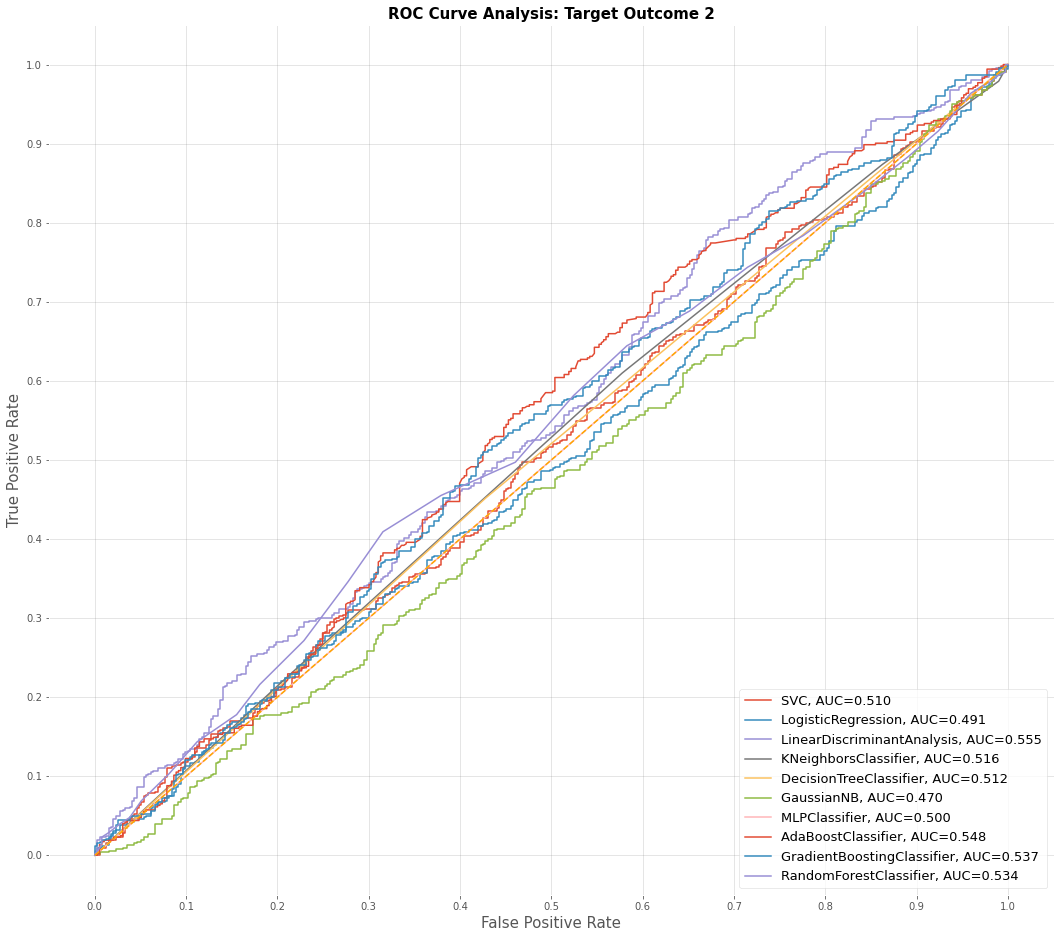

In [1460]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train2, Y_train2)
    yproba = model.predict_proba(X_test2)[::,1]
    
    fpr, tpr, _ = roc_curve(Y_test2,  yproba)
    auc = roc_auc_score(Y_test2, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

# Plot ROC_AUC
fig = plt.figure(figsize=(18,16))
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis: Target Outcome 2', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### Model Selection Findings

Based on the results of the `Accuracy box plot` from cross validation, as well as `ROC_AUC`, we find that the models are more successful in predicting Target Outcome 2: Open (SPY)

We will focus on building a strategy based on the best performing Supervised Algorithms to trade on SPY Open. The strategy will focus on opening a position at Open and close position at following day's Open.

We will assess the below best performing algorithms:

* Linear Discriminant Analysis
* AdaBoost
* GradientBoost
* RandomForest

### Model development

We will proceed with the following steps:
* Hyper-parameter tuning via Grid Search
* Strategy assessment compared to Benchmark (Buy and Hold)

To assess the performance of each model, we will look at:
* Accuracy rate
* Confusion matrix
* Equity curve


**Hyper-parameter Tuning: Linear Discriminant Analysis**

Since LDA is a closed-form formula, the only hyperparameter is to choose the type of solver.

Summary of performance metrics:
* Out-of-sample prediction: 55.02%
* F1 score for position 1: 69%
* AUC: 0.51

In [1267]:
# Grid Search: LDA
scaler = StandardScaler().fit(X_train2)
rescaledX = scaler.transform(X_train2)

solver = ['svd', 'lsqr', 'eigen']

param_grid = dict(solver = solver)

model = LinearDiscriminantAnalysis()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(rescaledX, Y_train2)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.583790 using {'solver': 'lsqr'}
#3 0.583789 (0.018929) with: {'solver': 'svd'}
#1 0.583790 (0.019029) with: {'solver': 'lsqr'}
#1 0.583790 (0.019029) with: {'solver': 'eigen'}


In [1454]:
# prepare model based on tuned hyperparameters
model = LinearDiscriminantAnalysis(solver='lsqr')
model.fit(X_train2, Y_train2)

LinearDiscriminantAnalysis(solver='lsqr')

In [1455]:
# estimate accuracy on validation set
predictions = model.predict(X_test2)

print(accuracy_score(Y_test2, predictions))
print(confusion_matrix(Y_test2, predictions))
print(classification_report(Y_test2, predictions))

0.5502183406113537
[[ 52 341]
 [ 71 452]]
              precision    recall  f1-score   support

         0.0       0.42      0.13      0.20       393
         1.0       0.57      0.86      0.69       523

    accuracy                           0.55       916
   macro avg       0.50      0.50      0.44       916
weighted avg       0.51      0.55      0.48       916



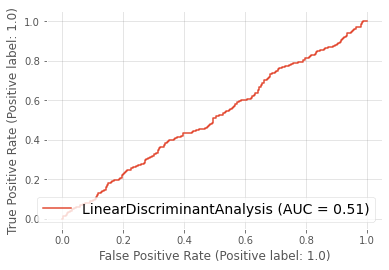

In [1456]:
# plot roc ruve
from sklearn import metrics

metrics.plot_roc_curve(model, X_test2, Y_test2)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

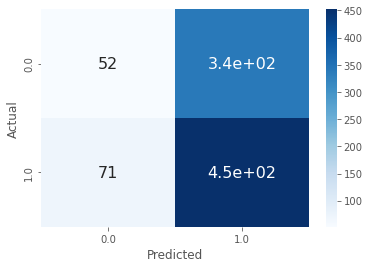

In [1457]:
df_cm = pd.DataFrame(confusion_matrix(Y_test2, predictions), 
                     columns=np.unique(Y_test2), 
                     index = np.unique(Y_test2)
                    )

df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"

sns.heatmap(df_cm, 
            cmap="Blues", 
            annot=True,
            annot_kws={"size": 16}
           ) # font sizes

<AxesSubplot:xlabel='Date'>

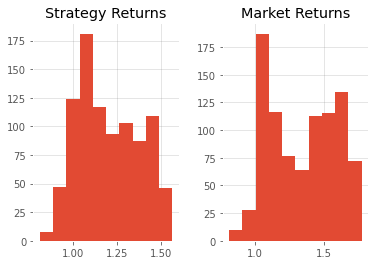

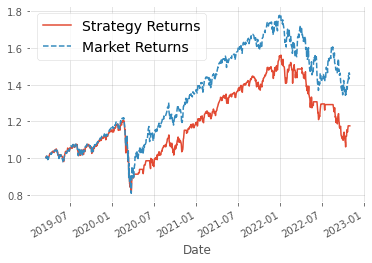

In [1458]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtest_lda = pd.DataFrame(index=X_test2.index)

#backtestdata = pd.DataFrame()

backtest_lda["signal_pred"] = predictions
backtest_lda["signal_actual"] = Y_test2
# using X_test1 as X_test2 Adj close is shifted to account for forward bias
backtest_lda['Market Returns'] = np.log(X_test1['Adj Close'][1:]/ X_test1['Adj Close'][1:].shift(1)).fillna(0)
backtest_lda["Open Returns"] = np.log(X2['Open']/ X2['Open'].shift(1)).fillna(0)
backtest_lda["Actual Returns"] = backtest_lda["Market Returns"] * backtest_lda["signal_actual"].shift(1)
backtest_lda["Strategy Returns"] = backtest_lda["Open Returns"] * backtest_lda["signal_pred"].shift(1)

backtest_lda[["Strategy Returns","Market Returns"]].cumsum().apply(np.exp).hist()
backtest_lda[["Strategy Returns","Market Returns"]].cumsum().apply(np.exp).plot(style=["-","--"])

**Hyper-parameter Tuning: Gradient Boosting Classifier**

Using the hyperparameter tuned model, we are able to assess the performance of the strategy based on this algorithm.

Summary of performance metrics:
* Out-of-sample prediction: 47.27%
* F1-score for position 1: 38%
* AUC: 0.52

In [1274]:
# Grid Search: Gradient Boosting Classifier
scaler = StandardScaler().fit(X_train2)
rescaledX = scaler.transform(X_train2)

n_estimators = [20,80]
max_depth = [5,10]
learning_rate = [0.1,1,10]

criterion = ['friedman_mse','squared_error']

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, criterion = criterion)

model = GradientBoostingClassifier()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(rescaledX, Y_train2)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.566868 using {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 20}
#1 0.566868 (0.019195) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 20}
#3 0.561962 (0.012813) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}
#5 0.553495 (0.015232) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 20}
#2 0.566325 (0.014931) with: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}
#8 0.530295 (0.019954) with: {'criterion': 'friedman_mse', 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 20}
#6 0.543414 (0.022724) with: {'criterion': 'friedman_mse', 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 80}
#7 0.540931 (0.021704) with: {'criterion': 'friedman_mse', 'learning_rate': 1, 'max_depth': 10, 'n_estimators': 20}
#4 0.560051 (0.022623) with: {'criterion': 'friedman_mse', 'learning_rate':

In [1448]:
# prepare model based on tuned hyperparameters
model = GradientBoostingClassifier(n_estimators = 20,
                               max_depth = 5,
                               learning_rate = 0.1,
                               criterion = 'friedman_mse',
                               random_state = seed)
model.fit(X_train2, Y_train2)

GradientBoostingClassifier(max_depth=5, n_estimators=20, random_state=1)

In [1449]:
# estimate accuracy on validation set
predictions = model.predict(X_test2)

print(accuracy_score(Y_test2, predictions))
print(confusion_matrix(Y_test2, predictions))
print(classification_report(Y_test2, predictions))

0.47270742358078605
[[286 107]
 [376 147]]
              precision    recall  f1-score   support

         0.0       0.43      0.73      0.54       393
         1.0       0.58      0.28      0.38       523

    accuracy                           0.47       916
   macro avg       0.51      0.50      0.46       916
weighted avg       0.52      0.47      0.45       916



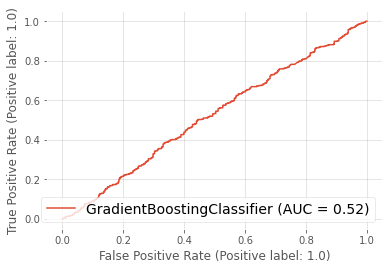

In [1450]:
# plot roc ruve
from sklearn import metrics

metrics.plot_roc_curve(model, X_test2, Y_test2)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

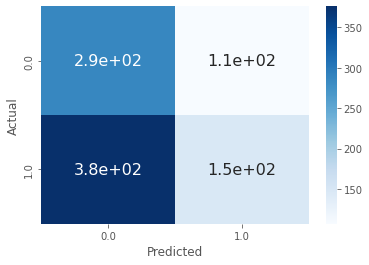

In [1451]:
df_cm = pd.DataFrame(confusion_matrix(Y_test2, predictions), 
                     columns=np.unique(Y_test2), 
                     index = np.unique(Y_test2)
                    )

df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"

sns.heatmap(df_cm, 
            cmap="Blues", 
            annot=True,
            annot_kws={"size": 16}
           ) # font sizes

Text(0.5, 0, 'Variable Importance')

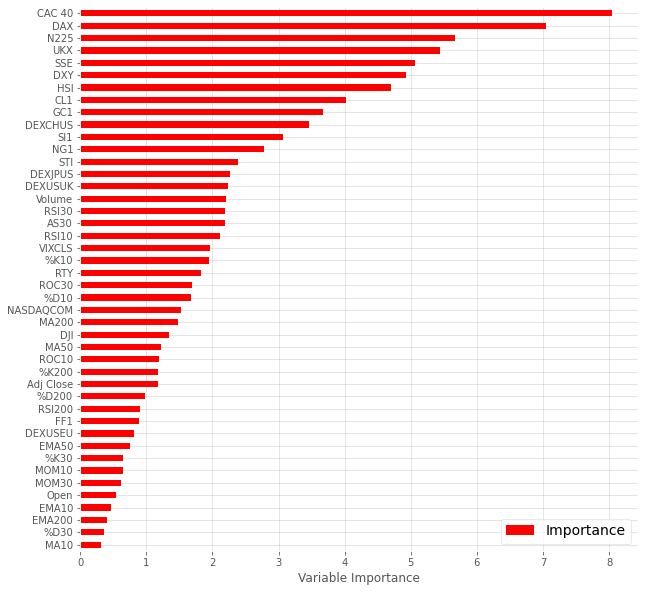

In [1452]:
Importance = pd.DataFrame({"Importance":model.feature_importances_*100}, 
                          index=X2.columns)
Importance.sort_values("Importance", 
                       axis = 0, 
                       ascending = True).plot(kind="barh", color="r", figsize=(10,10))
plt.xlabel("Variable Importance")

<AxesSubplot:>

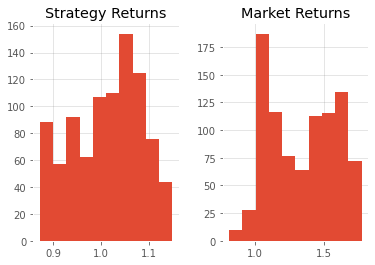

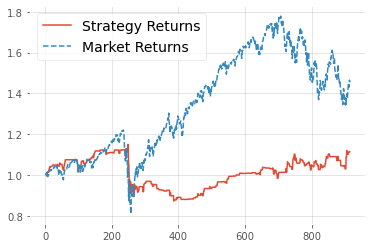

In [1453]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtest_gb = pd.DataFrame(index=X_test2.index)

#backtestdata = pd.DataFrame()

backtest_gb["signal_pred"] = predictions
backtest_gb["signal_actual"] = Y_test2
# using X_test1 as X_test2 Adj close is shifted to account for forward bias
backtest_gb['Market Returns'] = np.log(X_test1['Adj Close'][1:]/ X_test1['Adj Close'][1:].shift(1)).fillna(0)
backtest_gb["Open Returns"] = np.log(X2['Open']/ X2['Open'].shift(1)).fillna(0)
backtest_gb["Actual Returns"] = backtest_gb["Market Returns"] * backtest_gb["signal_actual"].shift(1)
backtest_gb["Strategy Returns"] = backtest_gb["Open Returns"] * backtest_gb["signal_pred"].shift(1)

backtest_gb = backtest_gb.reset_index()

backtest_gb[["Strategy Returns","Market Returns"]].cumsum().apply(np.exp).hist()
backtest_gb[["Strategy Returns","Market Returns"]].cumsum().apply(np.exp).plot(style=["-","--"])

**Hyper-parameter Tuning: Random Forest Classifier**

Using the hyperparameter tuned model, we are able to assess the performance of the strategy based on this algorithm.

Summary of performance metrics:
* Out-of-sample prediction: 49.45%
* F1 score for Buy: 33%
* AUC: 0.58

In [1280]:
# Grid Search: Random Forest Classifier
scaler = StandardScaler().fit(X_train2)
rescaledX = scaler.transform(X_train2)

n_estimators = [20,80]
max_depth= [5,10]

criterion = ["gini","entropy"]

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth, 
                  criterion = criterion )

model = RandomForestClassifier(n_jobs = -1)

kfold = KFold(n_splits = num_folds, 
              random_state = seed,
              shuffle=True)

grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid, 
                    scoring = scoring, 
                    cv = kfold)

grid_result = grid.fit(rescaledX, Y_train2)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.579158 using {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#7 0.573150 (0.021585) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#4 0.574507 (0.015783) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.575067 (0.019059) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#5 0.573971 (0.012547) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#2 0.579156 (0.020035) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#1 0.579158 (0.019323) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#8 0.568243 (0.020786) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#6 0.573707 (0.021484) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [1583]:
# prepare model
model = RandomForestClassifier(criterion = "entropy", 
                               n_estimators = 80,
                               max_depth = 5,
                               n_jobs = -1,
                               random_state = seed)
                               
model.fit(X_train2, Y_train2)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=80,
                       n_jobs=-1, random_state=1)

In [1584]:
# estimate accuracy on validation set
predictions = model.predict(X_test2)

print(accuracy_score(Y_test2, predictions))
print(confusion_matrix(Y_test2, predictions))
print(classification_report(Y_test2, predictions))

0.4945414847161572
[[337  56]
 [407 116]]
              precision    recall  f1-score   support

         0.0       0.45      0.86      0.59       393
         1.0       0.67      0.22      0.33       523

    accuracy                           0.49       916
   macro avg       0.56      0.54      0.46       916
weighted avg       0.58      0.49      0.44       916



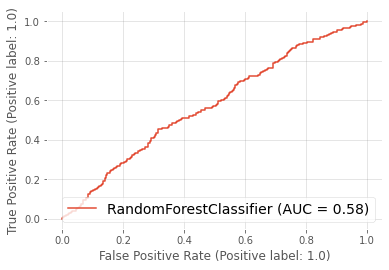

In [1447]:
# plot roc ruve
from sklearn import metrics

metrics.plot_roc_curve(model, X_test2, Y_test2)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

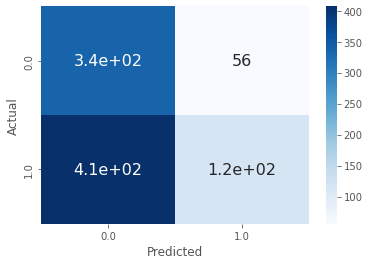

In [1446]:
df_cm = pd.DataFrame(confusion_matrix(Y_test2, predictions), 
                     columns=np.unique(Y_test2), 
                     index = np.unique(Y_test2)
                    )

df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"

sns.heatmap(df_cm, 
            cmap="Blues", 
            annot=True,
            annot_kws={"size": 16}
           ) # font sizes

Text(0.5, 0, 'Variable Importance')

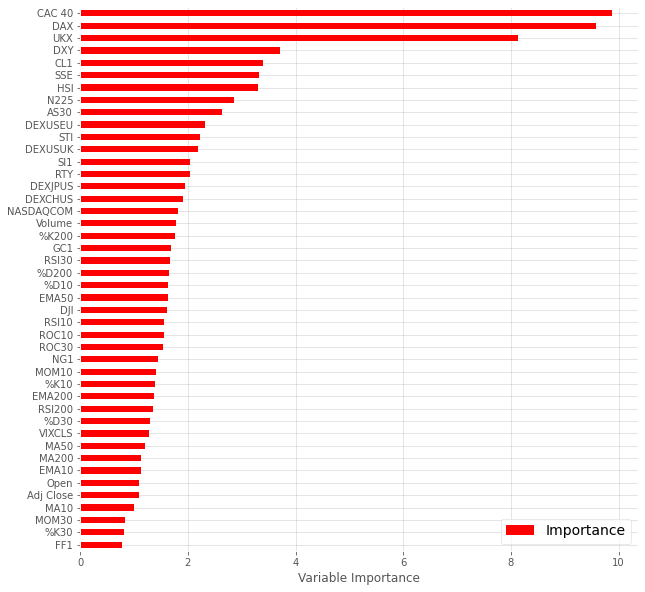

In [1445]:
Importance = pd.DataFrame({"Importance":model.feature_importances_*100}, 
                          index=X2.columns)
Importance.sort_values("Importance", 
                       axis = 0, 
                       ascending = True).plot(kind="barh", color="r", figsize=(10,10))

plt.xlabel("Variable Importance")

<AxesSubplot:xlabel='Date'>

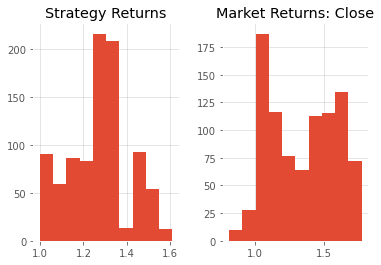

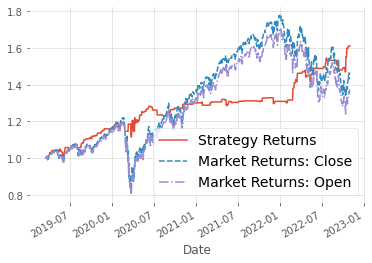

In [1585]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtest_rf = pd.DataFrame(index=X_test2.index)

backtest_rf["signal_pred"] = predictions
backtest_rf["signal_actual"] = Y_test2
# using X_test1 as X_test2 Adj close is shifted to account for forward bias
backtest_rf['Market Returns: Close'] = np.log(X_test1['Adj Close'][1:]/ X_test1['Adj Close'][1:].shift(1)).fillna(0)
backtest_rf["Market Returns: Open"] = np.log(X2['Open']/ X2['Open'].shift(1)).fillna(0)
backtest_rf["Strategy Returns"] = backtest_rf["Market Returns: Open"] * backtest_rf["signal_pred"].shift(1)

backtest_rf[["Strategy Returns","Market Returns: Close"]].cumsum().apply(np.exp).hist()
backtest_rf[["Strategy Returns","Market Returns: Close","Market Returns: Open"]].cumsum().apply(np.exp).plot(style=["-","--","-."])

**Hyper-parameter Tuning: AdaBoost Classifier**

Using the hyperparameter tuned model, we are able to assess the performance of the strategy based on this algorithm.

Summary of performance metrics:
* Out-of-sample prediction: 58.30%
* F1 score for Buy: 66%
* AUC: 0.57

In [1286]:
# Grid Search: AdaBoost Classifier
scaler = StandardScaler().fit(X_train2)
rescaledX = scaler.transform(X_train2)

n_estimators = [20,80]
learning_rate = [0.1,1,10]

algorithm = ["SAMME","SAMME.R"]

param_grid = dict(n_estimators = n_estimators, 
                  learning_rate = learning_rate, 
                  algorithm = algorithm )

model = AdaBoostClassifier()

kfold = KFold(n_splits = num_folds, 
              random_state = seed,
              shuffle=True)

grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid, 
                    scoring = scoring, 
                    cv = kfold)

grid_result = grid.fit(rescaledX, Y_train2)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.578606 using {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 20}
#7 0.552947 (0.012839) with: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 20}
#3 0.573159 (0.020746) with: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 80}
#1 0.578606 (0.015919) with: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 20}
#5 0.565505 (0.010720) with: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 80}
#11 nan (nan) with: {'algorithm': 'SAMME', 'learning_rate': 10, 'n_estimators': 20}
#12 nan (nan) with: {'algorithm': 'SAMME', 'learning_rate': 10, 'n_estimators': 80}
#4 0.573152 (0.020848) with: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 20}
#2 0.576700 (0.016724) with: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 80}
#6 0.559488 (0.017310) with: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 20}
#8 0.543665 (0.027491) with: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 

In [1575]:
# prepare model
model = AdaBoostClassifier(n_estimators = 20,
                               learning_rate = 1,
                               algorithm = 'SAMME',
                               random_state = seed)
                               
model.fit(X_train2, Y_train2)

AdaBoostClassifier(algorithm='SAMME', learning_rate=1, n_estimators=20,
                   random_state=1)

In [1576]:
# estimate accuracy on validation set
predictions = model.predict(X_test2)

print(accuracy_score(Y_test2, predictions))
print(confusion_matrix(Y_test2, predictions))
print(classification_report(Y_test2, predictions))

0.5829694323144105
[[163 230]
 [152 371]]
              precision    recall  f1-score   support

         0.0       0.52      0.41      0.46       393
         1.0       0.62      0.71      0.66       523

    accuracy                           0.58       916
   macro avg       0.57      0.56      0.56       916
weighted avg       0.57      0.58      0.57       916



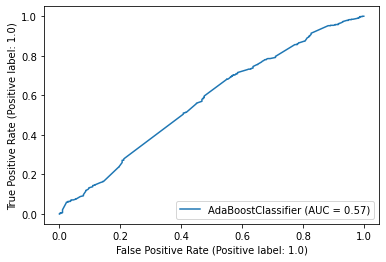

In [1306]:
# plot roc ruve
from sklearn import metrics

metrics.plot_roc_curve(model, X_test2, Y_test2)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

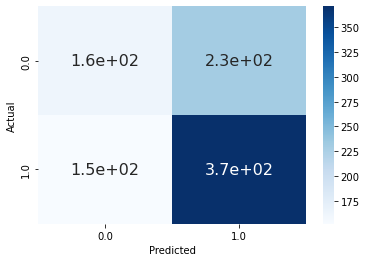

In [1289]:
df_cm = pd.DataFrame(confusion_matrix(Y_test2, predictions), 
                     columns=np.unique(Y_test2), 
                     index = np.unique(Y_test2)
                    )

df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"

sns.heatmap(df_cm, 
            cmap="Blues", 
            annot=True,
            annot_kws={"size": 16}
           ) # font sizes

Text(0.5, 0, 'Variable Importance')

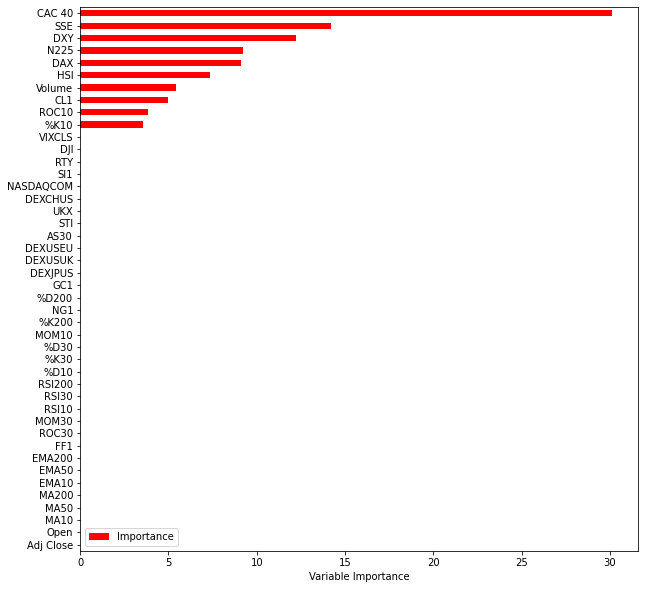

In [1290]:
Importance = pd.DataFrame({"Importance":model.feature_importances_*100}, 
                          index=X2.columns)
Importance.sort_values("Importance", 
                       axis = 0, 
                       ascending = True).plot(kind="barh", color="r", figsize=(10,10))

plt.xlabel("Variable Importance")

<AxesSubplot:xlabel='Date'>

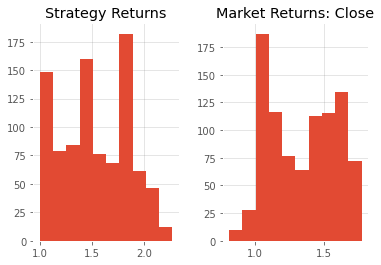

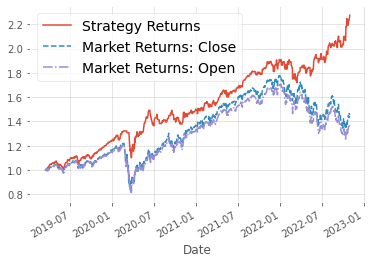

In [1577]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtest_ab = pd.DataFrame(index=X_test2.index)

backtest_ab["signal_pred"] = predictions
backtest_ab["signal_actual"] = Y_test2
# using X_test1 as X_test2 Adj close is shifted to account for forward bias
backtest_ab["Market Returns: Close"] = np.log(X_test1['Adj Close'][1:]/ X_test1['Adj Close'][1:].shift(1)).fillna(0)
backtest_ab["Market Returns: Open"] = np.log(X_test2['Open']/ X_test2['Open'].shift(1)).fillna(0)
backtest_ab["Strategy Returns"] = (backtest_ab["Market Returns: Open"] * backtest_ab["signal_pred"].shift(1)).fillna(0)

backtest_ab[["Strategy Returns","Market Returns: Close"]].cumsum().apply(np.exp).hist()
backtest_ab[["Strategy Returns","Market Returns: Close","Market Returns: Open"]].cumsum().apply(np.exp).plot(style=["-","--","-."])

### Potential improvements via Dimensionality reduction

> While using unsupervised learning for our supervised algorithms is able to help reduce number of features with greatest explained variance within smaller number of components, in our case the number of features were not necessarily numerous.

> We can consider using PCA or SVD in production when scaling our algorithm and strategy to include hundreds or thousands of features, so as to streamline the computational time.

> We explore the potential of using SVD in our AdaBoost algorithm, and check if we are able to use the reduced dimensions to help us in our training, hyperparameter tuning and overall efficacy in the validation.

Variance preserved by first 10 components == 80.17%


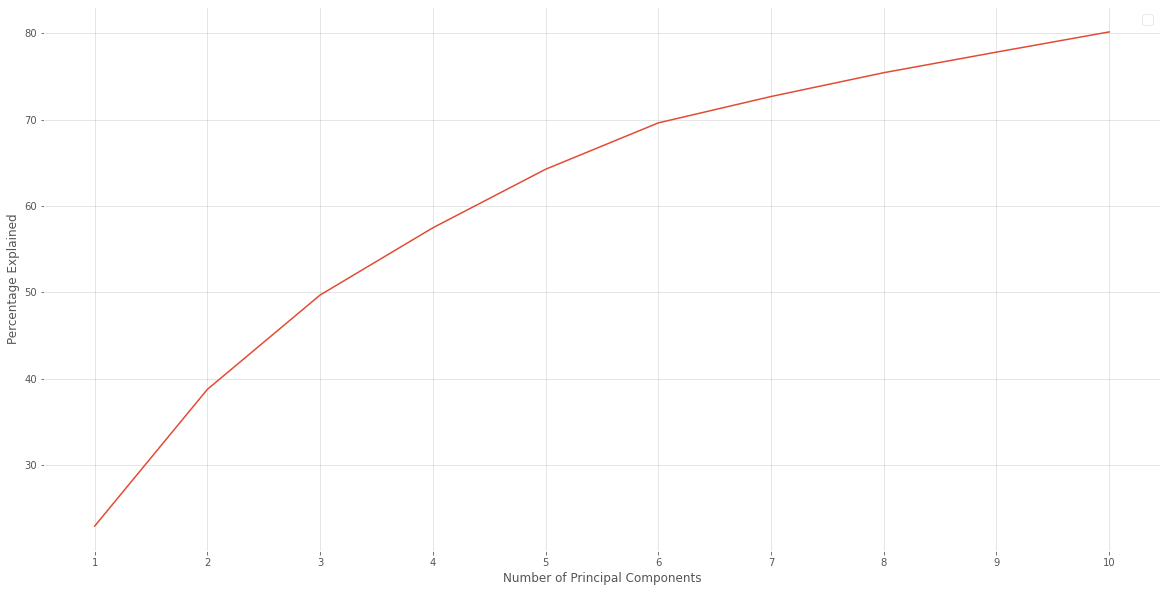

In [1555]:
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib.ticker import MaxNLocator

scaler = StandardScaler().fit(X_train2)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train2),columns = X_train2.columns, index = X_train2.index)

# SVD
ncomps = 10
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind="line", figsize=(20, 10))
ax.xaxis.set_major_locator(MaxNLocator(integer = True)
                          )

ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print("Variance preserved by first 10 components == {:.2%}".format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

> We ty to use 6 components as seen in the kink above

Variance preserved by first 6 components == 69.63%


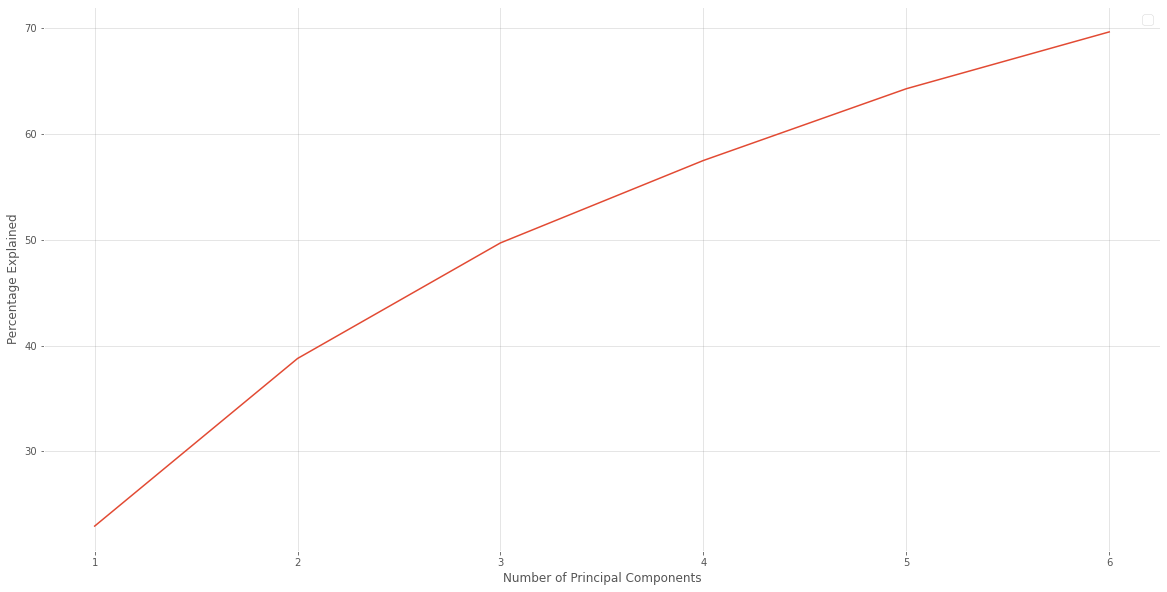

In [1556]:
scaler = StandardScaler().fit(X_train2)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train2),columns = X_train2.columns, index = X_train2.index)

# SVD
ncomps = 6
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind="line", figsize=(20, 10))
ax.xaxis.set_major_locator(MaxNLocator(integer = True)
                          )

ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print("Variance preserved by first 6 components == {:.2%}".format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [1557]:
# 6 components
dfsvd = pd.DataFrame(Y_pred, columns=["c{}".format(c) for c in range(ncomps)], 
                     index = rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(3664, 6)


,c0,c1,c2,c3,c4,c5
Date,,,,,,
2004-08-24,-4.187482,-0.349727,-1.434894,0.788934,-3.258935,-0.025229
2004-08-25,-4.140273,-1.422589,-0.549633,-0.724040,-1.184416,0.871436
2004-08-26,-3.945645,-2.155733,-0.580527,-0.534868,-0.704621,0.879607
2004-08-27,-3.941059,-1.142691,-1.326413,0.127074,-1.888590,-0.320794
2004-08-30,-3.918194,-1.448673,-1.357635,-0.703559,0.118616,1.145309


In [1559]:
# test options for classification
scoring = "accuracy"
kfold = 10

import time
start_time1 = time.time()

# use tuned algorithm
model = AdaBoostClassifier(n_estimators = 20,
                               learning_rate = 1,
                               algorithm = 'SAMME',
                               random_state = seed)

cv_results_XTrain= cross_val_score(model, X_train2, Y_train2, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction: %s seconds" % (time.time() - start_time1))

start_time2 = time.time()
X_SVD = dfsvd.iloc[:,:ncomps]
cv_results_SVD = cross_val_score(model, X_SVD, Y_train2, cv = kfold, scoring = scoring)
print("Time with Dimensionality Reduction: %s seconds" % (time.time() - start_time2))

Time Without Dimensionality Reduction: 3.257904529571533 seconds
Time with Dimensionality Reduction: 0.7280805110931396 seconds


In [1560]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.544788 (0.040696)
Result with dimensionality Reduction: 0.554337 (0.028937)


>`We were able to see vast improvements in Cross Validation computing time, with a slight improvement in accuracy`

### Model Selection and Strategy Performance

Based on the assessment metrics of the Top 4 models, the best model to run a strategy on would be `AdaBoost Classifier` based on the metrics below:

* ROC AUC
* Validation accuracy score
* F1-score for going long (Position 1)
* Equity curve

Since the strategy is focused on investing, it is appropriate to base selection criteria on F1-score for Long positions.

In [1586]:
# get arithmetic returns
ab_ret = backtest_ab['Strategy Returns'].apply(np.exp) - 1
rf_ret = backtest_rf['Strategy Returns'].apply(np.exp) - 1
market_ret = backtest_ab['Market Returns: Close'].apply(np.exp) - 1

> We backtest the strategy based on AdaBoost on the validation set, using `$500,000` capital.

> Few assumptions to note:
* Strategy is long only
* Strategy is trading on positions based on SPY open prices (position entry and exit on market open)
* No commission fees involved

We note the below strategy metric comparisons:
* AdaBoost strategy has almost 3x Sharpe ratio of Benchmark (Buy and Hold), with superiod risk-adjusted returns
* Max Drawdown is half of Benchmark
* AdaBoost strategy has 10% higher compound annual growth rate
* AdaBoost strategy performs better during historical stress tests


Performance Statistics for Strategy: AdaBoost
Daily annualized sharpe: 1.556495463448531
Daily annualized sortino: 1.4714500077920845
Average annual returns: 23.785261453999034%
Total cumulative returns: 227.40266447319334%
Max drawdown: -16.635083970345953%


Performance Statistics for Benchmark
Daily annualized sharpe: 0.5659579826073605
Daily annualized sortino: 0.6715176188685994
Average annual returns: 12.936388282456871%
Total cumulative returns: 145.43277681125176%
Max drawdown: -33.717217622861185%



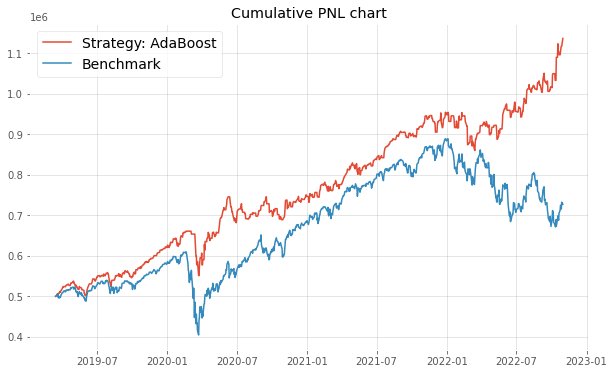


Total Return
Return: Portfolio
Period return YTD: 19.2680332962992%
Period return 1y: 23.948383833535015%
Period return 3y: 96.86153952715628%
Period return 2021: 26.884655023069737%
Period return 2020: 20.302129393246293%
Period return 2019: 24.122210945873455%

Return: Benchmark
Period return YTD: -17.951615986979498%
Period return 1y: -14.458427775285509%
Period return 3y: 33.249546063081034%
Period return 2021: 29.382820762970184%
Period return 2020: 18.619082313384496%
Period return 2019: 16.069978755070345%

Annualized Return
Period return All-time: 25.35963745189629%
Period return 3y: 14.507036597708467%

Period return All-time: 10.853622433192989%
Period return 3y: 5.909068336250578%

Stress Tests
Stressed period return during Inflation22: -3.4958587746079295%
Stressed period return during Covid19: -16.62276303907566%

Stressed period return during Inflation22: -12.48876283595315%
Stressed period return during Covid19: -24.302650384069725%



In [1594]:
backtest(ab_ret,market_ret,500000,'Strategy: AdaBoost')

> We backtest the next strategy based on Random Forest on the validation set, using `$500,000` capital.

> Few assumptions to note:
* Strategy is long only
* Strategy is trading on positions based on SPY open prices (position entry and exit on market open)
* No commission fees involved

We note the below strategy metric comparisons:
* Random Forest strategy has more than 2x Sharpe ratio of Benchmark (Buy and Hold), with superiod risk-adjusted returns
* Max Drawdown is minimal at -6.64%, as algorithm has high accuracy for prediction 0 position
* Random Forest strategy has similar compound annual growth rate, at less than half the volatility
* Random Forest strategy performs better during historical stress tests


Performance Statistics for Strategy: Random Forest
Daily annualized sharpe: 1.3772961456529584
Daily annualized sortino: 0.7227413821670886
Average annual returns: 13.63052195989162%
Total cumulative returns: 161.13797193414683%
Max drawdown: -6.638122220221312%


Performance Statistics for Benchmark
Daily annualized sharpe: 0.5659579826073605
Daily annualized sortino: 0.6715176188685994
Average annual returns: 12.936388282456871%
Total cumulative returns: 145.43277681125176%
Max drawdown: -33.717217622861185%



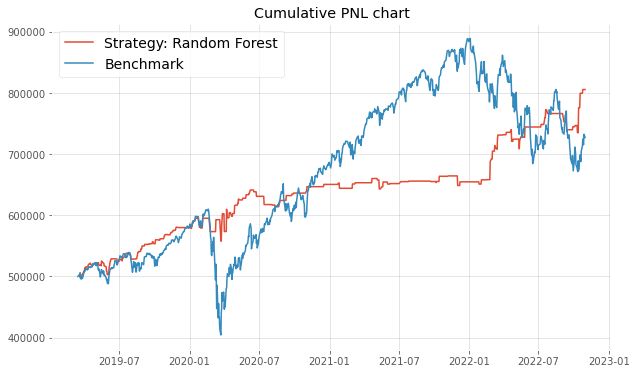


Total Return
Return: Portfolio
Period return YTD: 23.058044151494773%
Period return 1y: 21.368214665091134%
Period return 3y: 41.69586579440241%
Period return 2021: 0.6416274896200891%
Period return 2020: 12.207026513786868%
Period return 2019: 15.955186885838323%

Return: Benchmark
Period return YTD: -17.951615986979498%
Period return 1y: -14.458427775285509%
Period return 3y: 33.249546063081034%
Period return 2021: 29.382820762970184%
Period return 2020: 18.619082313384496%
Period return 2019: 16.069978755070345%

Annualized Return
Period return All-time: 14.025514503186942%
Period return 3y: 7.2189218539292055%

Period return All-time: 10.853622433192989%
Period return 3y: 5.909068336250578%

Stress Tests
Stressed period return during Inflation22: -3.888860868401045%
Stressed period return during Covid19: -2.7205941584051763%

Stressed period return during Inflation22: -12.48876283595315%
Stressed period return during Covid19: -24.302650384069725%



In [1593]:
backtest(rf_ret,market_ret,500000,'Strategy: Random Forest')

<a id="results"></a>
### Strategy Selection Ranking and Final Summary

`Based on the results of momentum, mean-reversion, and Machine Learning-based Strategies, the best performing strategies according to cumulative returns are:` 

1. `AdaBoost Classifier Strategy`

> The Adaptive Boosting technicle is an ensemble ML method which places more importance on wrongly classified data like, in this case, opening prices of the SPY. It does so by assigning higher weights to the prices and strives to reduce prediction errors. 
>
> In this project, algorithms like AdaBoost and Random Forest below, were used to predict whether the next SPY price would be showing an upward movement. Variables used to train the models includes major economy and commodity indices, major FX pairs, and EWA of past SPY prices. The project investigated predicting SPY Open (Target Outcome 2) and Adj. Close (Target Outcome 1) prices and discovered that predictions for Open prices were better than those for the latter.
>
> Referring to the models' ROC Curves for Opening price, AUC for AdaBoost, Gradient Boost, and Random Forest performed the best. Hence, these models were selected for hyperparameter tuning and their results generated signals to buy the SPY. 
>
> Upon testing the models on 20% of the SPY dataset (2018 - 2022), it is noted that AdaBoost performed the best when compared to other models in this project.
>
> It's cumulative returns, Sharpe ratio and CAGR shown below are the best when compared to other models in this project. When contrasted against just holding SPY, AdaBoost-trained model produces a Sharpe ratio of 1 more than that of just holding SPY and makes 50% more in terms of total cumulative return. 
> 
> However, it may not be better than the Random Forest model when it comes to max drawdown. The drawdown of AdaBoost is around 10% more than that for Random Forest. 

* Highest sharpe ratio of 1.56
* Best total cumulative return of 227.40%
* Highest ending value of $1,137,013.30
* Highest CAGR of 23.79%
* 2nd lowest Max Drawdown of 16.6%

2. `Random Forest Classifier Strategy`

* 2nd highest sharpe ratio of 1.38
* 2nd best total cumulative return of 161.14%
* 2nd highest ending value of $805,689.86
* CAGR of 13.63%
* Lowest Max Drawdown of 6.64%

> Just like the AdaBoost model, the Random Forest is also a ML algorithm. It makes use of multiple decision trees to produce a prediction on the upward action of the next SPY price. RF is the top scorer for AUC, coming in higher than AdaBoost. Hence, it was shortlisted for hyperparameter tuning and strategy construction.
>
> Similarly to AdaBoost, after tuning RF parameters, the model was used to construct signals to long the SPY. It's Sharpe ratio of 1.38 is much higher than the other models, demonstrating better risk to reward. Its total cumulative return is also 20% higher than just holding the SPY, showing that it beats the benchmark quite well.
>
> Among the top 3 models, RF has a max drawdown of 6.64%, which is impressive especially given the 33% drawdown just by holding SPY. This lends RF further possibility of being a good strategy for predicting long signals for SPY.

3. `Max-Sharpe rolling SD Mean Reversion`

* Sharpe ratio of 0.67
* Total cumulative return of 158.49%
* Ending value of $792,439.85
* CAGR of 15.30%
* Max Drawdown of 28.32%

> The 3rd highest cumulative return strategy is an enhanced Mean Reversion strategy. This project first constructed a Mean Reversion strategy with standard deviations as thresholds for trading signals. With an iterative function to find the best window period period and number of standard deviations, the project found that a period of 20 and SD of 6 produced the best cumulative returns (112%). However, that does not beat holding the SPY directly, which gives 145%. There were also considerations of there not being enough trading opportunities due to the 6 SD breakout requirement.
>
> The project sought to improve the Mean Reversion strategy by finding the optimal parameters to produce the best Sharpe in a rolling window period. After this tuning process, the window and SD were fed into the testing set (2018 - 2022) to ensure consistency with the other 2 ML models. 
>
> This new Mean Reversion Strategy achieved total cumulative returns of 158% compared to that of 145% for holding the SPY and achieved a good CAGR of 15%. Its Sharpe ratio was less optimal at 0.67, beating the benchmark by only 0.1. Its max drawdown of 28% also makes it a much less agreeable strategy than AdaBoost- or RF-predicted signals. However, the max drawdown is still better just holding SPY (33%).
>
> Overall, we conclude that the ML strategies - AdaBoost and Random Forest are more superior in terms of total cumulative returns and max drawdowns. Their resulting Sharpe ratios are also better than that of Mean Reversion. In a practical context, the max drawdown of the rolling Mean Reversion possibly renders undesirable for trading. 
>
> While ML is highly adaptive and computationally powerful, the world of finance is still complex. It is important to constantly calibrate the model, and to check for biases to ensure that the model used and strategy is able to handle robustness checks. Re-tuning hyperparameters once in a while will also help ensure robust strategies. This will give the highest probability of success in live trading.
>
> The team would also like to thank Professor Roh for his tireless work in teaching us the practical applications of Machine Learning and Computational Finance